
-----------------------------------------------------------------------------------------

**Note: This notebook will take 5-6 minutes to run through from start to finish. The majority of this execution time is spent in section 5 where the random forest model is experimented with different values and in cleaning, predicting on new dataset.**

This homework consists of total 3 notebooks which are listed below:
1. Assignment2_Data_Cleaning_solution_COMP47350_CDC
    - The original dataset which is provided for homework 1 is taken performed data cleaning along with creating 3 new features. The final dataset is then used as an input to the Homework2.
2. Assignment2_Data_Modelling_solution_COMP47350_CDC
    - The dataset from previous step is used for modelling and performed all the steps which are provided.
3. New_data_cleaning_homework_2_Q4.3
    - The new dataset for question 4.3 is taken done the data cleaning in the above mentioned file. The final csv after cleaning is taken as an input for modelling in question 4.3 of data modelling notebook(Step 2 notebook).

## Introduction
- The cleaned dataset for this assignment(as an input) can be found in the file Assignment2_Data_Cleaning_solution_COMP47350_CDC. 
- The above mentioned notebook is built and cleaned from the initial raw dataset till the addition of 3 new features.
- This notebook will apply the cleaned dataset from Task1 and use it to create 3 different models to predict whether an person dies or not.
 
- Each model will be a supervised learning model and the output will be a binary classification. 
- Also, the final good accurate model is trained with the full dataset and do the prediction on the new dataset. 

This homework will be broken down into 4 main parts:
1. We will review the dataset from homework one(re-done from begining as mentioned above) and decide on which features to use to build our model
2. We will create a Linear Regression model and analyse
3. We will create a Logistical Regression model and analyse
4. We will create a Random Forest model and analyse
5. We will then try to optimize each model  
6. We will then extract the good model and train it and predict the values with new dataset provided.
7. Summarise the results obtained.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.tree import export_graphviz
from sklearn import tree
import calendar
# import graphviz
# from graphviz import Source

# ignore warnings
import warnings
warnings.filterwarnings('ignore')


# (1) Data understanding and prep:

The original dataset from CDC has been cleaned (Task1 - redone from begining which is a repeat of homework 1) and is now imported as a starting point for this work. 

Futhermore, in addition a number of extra features were added (to to better capture the problem domain) that were not in the original dataset.
   - %deaths_every_30_days : Provides the percentage of people died for 30 days.
   - Seasons : Indicates in which season(Total 4 seasons) the person effected with COVID-19. This is extracted by converting the cdc_case_earliest_dt to month and then categoried into seasons.
   - Is_person_Waited_Or_Not: This feature indicates whether a person responded immediately(with in 5 days) when he/she got the symptoms after the reported date.
    


In [2]:
# read in the cleaned csv which is created from the date cleaning notebook.
df = pd.read_csv('CDC_1-3_cleaned_new_features_FOR_A2.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)


After importing the cleaned csv, we will inspect the data and feature of it.

In [3]:
# get the number of rows and columns in the dataframe.
df.shape

(9535, 13)

In [4]:
df.head()

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,percent,%deaths_every_30days,Seasons,Is_person_Waited_OR_Not
0,2020-12-01,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,0.012840,2.955426,Winter,0.0
1,2020-10-28,Laboratory-confirmed case,Female,10 - 19 Years,Missing,Missing,Missing,No,Missing,0.012840,3.080569,Autumn,0.0
2,2020-12-28,Laboratory-confirmed case,Female,30 - 39 Years,Missing,No,Missing,No,No,0.107759,2.955426,Winter,1.0
3,2020-07-28,Laboratory-confirmed case,Male,20 - 29 Years,"Black, Non-Hispanic",Missing,Missing,No,No,0.107759,4.191617,Summer,1.0
4,2020-12-02,Laboratory-confirmed case,Female,20 - 29 Years,Missing,No,Missing,No,Missing,0.012840,2.955426,Winter,0.0


In [5]:
df.dtypes

cdc_case_earliest_dt        object
current_status              object
sex                         object
age_group                   object
race_ethnicity_combined     object
hosp_yn                     object
icu_yn                      object
death_yn                    object
medcond_yn                  object
percent                    float64
%deaths_every_30days       float64
Seasons                     object
Is_person_Waited_OR_Not    float64
dtype: object

In [6]:
df.isna().sum()

cdc_case_earliest_dt       0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
percent                    0
%deaths_every_30days       0
Seasons                    0
Is_person_Waited_OR_Not    0
dtype: int64

From the above details, we can observe that among the newly created features there is a continous feature and a categorical feature as it is having seasons. Also, there are no null values in the dataset.

## 1. Data Understanding and Preparation.


#### Convert the datatypes to appropriate ones for further analysis

In [7]:
# select all the remaining object features to convert them into categorical
object_columns = df.select_dtypes(['object']).columns
object_columns

Index(['cdc_case_earliest_dt', 'current_status', 'sex', 'age_group',
       'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn',
       'medcond_yn', 'Seasons'],
      dtype='object')

In [8]:
#change each column and change the dtype as categorical
for column in object_columns:
    df[column] = df[column].astype('category')

In [9]:
# Change the data type of cdc_case_earliest_dt as it is a date feature.
df['cdc_case_earliest_dt'] = df['cdc_case_earliest_dt'].astype('datetime64[ns]')

In [10]:
# storing all the categorical features in a variable.
Category_features = df.select_dtypes(['category']).columns

In [11]:
# storing all the continous features in a variable
Numerical_features = df.select_dtypes(['float64']).columns

In [12]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
percent                           float64
%deaths_every_30days              float64
Seasons                          category
Is_person_Waited_OR_Not           float64
dtype: object

In [13]:
df.head()

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,percent,%deaths_every_30days,Seasons,Is_person_Waited_OR_Not
0,2020-12-01,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,0.012840,2.955426,Winter,0.0
1,2020-10-28,Laboratory-confirmed case,Female,10 - 19 Years,Missing,Missing,Missing,No,Missing,0.012840,3.080569,Autumn,0.0
2,2020-12-28,Laboratory-confirmed case,Female,30 - 39 Years,Missing,No,Missing,No,No,0.107759,2.955426,Winter,1.0
3,2020-07-28,Laboratory-confirmed case,Male,20 - 29 Years,"Black, Non-Hispanic",Missing,Missing,No,No,0.107759,4.191617,Summer,1.0
4,2020-12-02,Laboratory-confirmed case,Female,20 - 29 Years,Missing,No,Missing,No,Missing,0.012840,2.955426,Winter,0.0


#### 1.1 Now shuffle the rows before splitting the data.

In [14]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)


,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,percent,%deaths_every_30days,Seasons,Is_person_Waited_OR_Not
0,2020-12-01,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,0.012840,2.955426,Winter,0.0
1,2020-10-28,Laboratory-confirmed case,Female,10 - 19 Years,Missing,Missing,Missing,No,Missing,0.012840,3.080569,Autumn,0.0
2,2020-12-28,Laboratory-confirmed case,Female,30 - 39 Years,Missing,No,Missing,No,No,0.107759,2.955426,Winter,1.0
3,2020-07-28,Laboratory-confirmed case,Male,20 - 29 Years,"Black, Non-Hispanic",Missing,Missing,No,No,0.107759,4.191617,Summer,1.0
4,2020-12-02,Laboratory-confirmed case,Female,20 - 29 Years,Missing,No,Missing,No,Missing,0.012840,2.955426,Winter,0.0


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will extract all features except target feature.
- Then we will set "X" to be the extracted features in the dataframe i.e. we drop "death_yn" from the dataframe
- Then we will set "Y" with the target feature.

In [15]:
features = df.columns[df.columns != 'death_yn']

#Separate the input features and the target feature
X = df[features]
y = df.death_yn

# Split the dataset into two datasets: 70% training and 30% test
# set random_state=1 to always get the same sample set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


print("\nTarget feature death_yn total dataset counts:\n\n", y.value_counts())
print("\nTraining data death_yn counts:\n", y_train.value_counts())
print("\nTest data death_yn counts:\n", y_test.value_counts())
print("\n\n")
print("original range is: ",df.shape[0])
print("Training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])


Target feature death_yn total dataset counts:

 No     9210
Yes     325
Name: death_yn, dtype: int64

Training data death_yn counts:
 No     6441
Yes     233
Name: death_yn, dtype: int64

Test data death_yn counts:
 No     2769
Yes      92
Name: death_yn, dtype: int64



original range is:  9535
Training range (70%):	 rows 0 to 6674
test range (30%): 	 rows 6674 to 9535


The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train



##### 1.2.1 Plot the correlations between all the continuous features. 
Here there is only one continous feature i.e. '%deaths_every_30days', while the 'Is_person_Waited_Or_Not' is not a continous feature as it is having only 2 values(0 and 1) but these values are stored as a float values. Due to which it is represented as continous feature. On the other hand, the percentage feature have different values which can be considered for having a correlation. 
While the other datetime feature cannot be used for plotting and correlation as it is having date time values which is not possible.

Hence, even the dataset consists of numerical features, in general these are not useful for having a correlation between them. Even if we have correlation table the percentage deaths for every 30 days feature will be only feature which can provide as others can not have correlation.

Therefore, the correlation can not be determined with one feature. **Hence there is no plot for correlation in the dataset.**

##### 1.2.2 For each continous feature, plot its interaction with the target feature.

According to the dataset '%deaths_for_every_30_days' and 'Is_person_waited_or_Not' are considered as numerical features. Hence the interartion between these features with the target feature is plotted below though among which 1 feature is not a continous column.


In [16]:
# For the time being we will add the target feature and other features from training set into a single dataframe for plotting purposes.
df_temp = pd.concat([X_train, y_train], axis=1)

<AxesSubplot:>

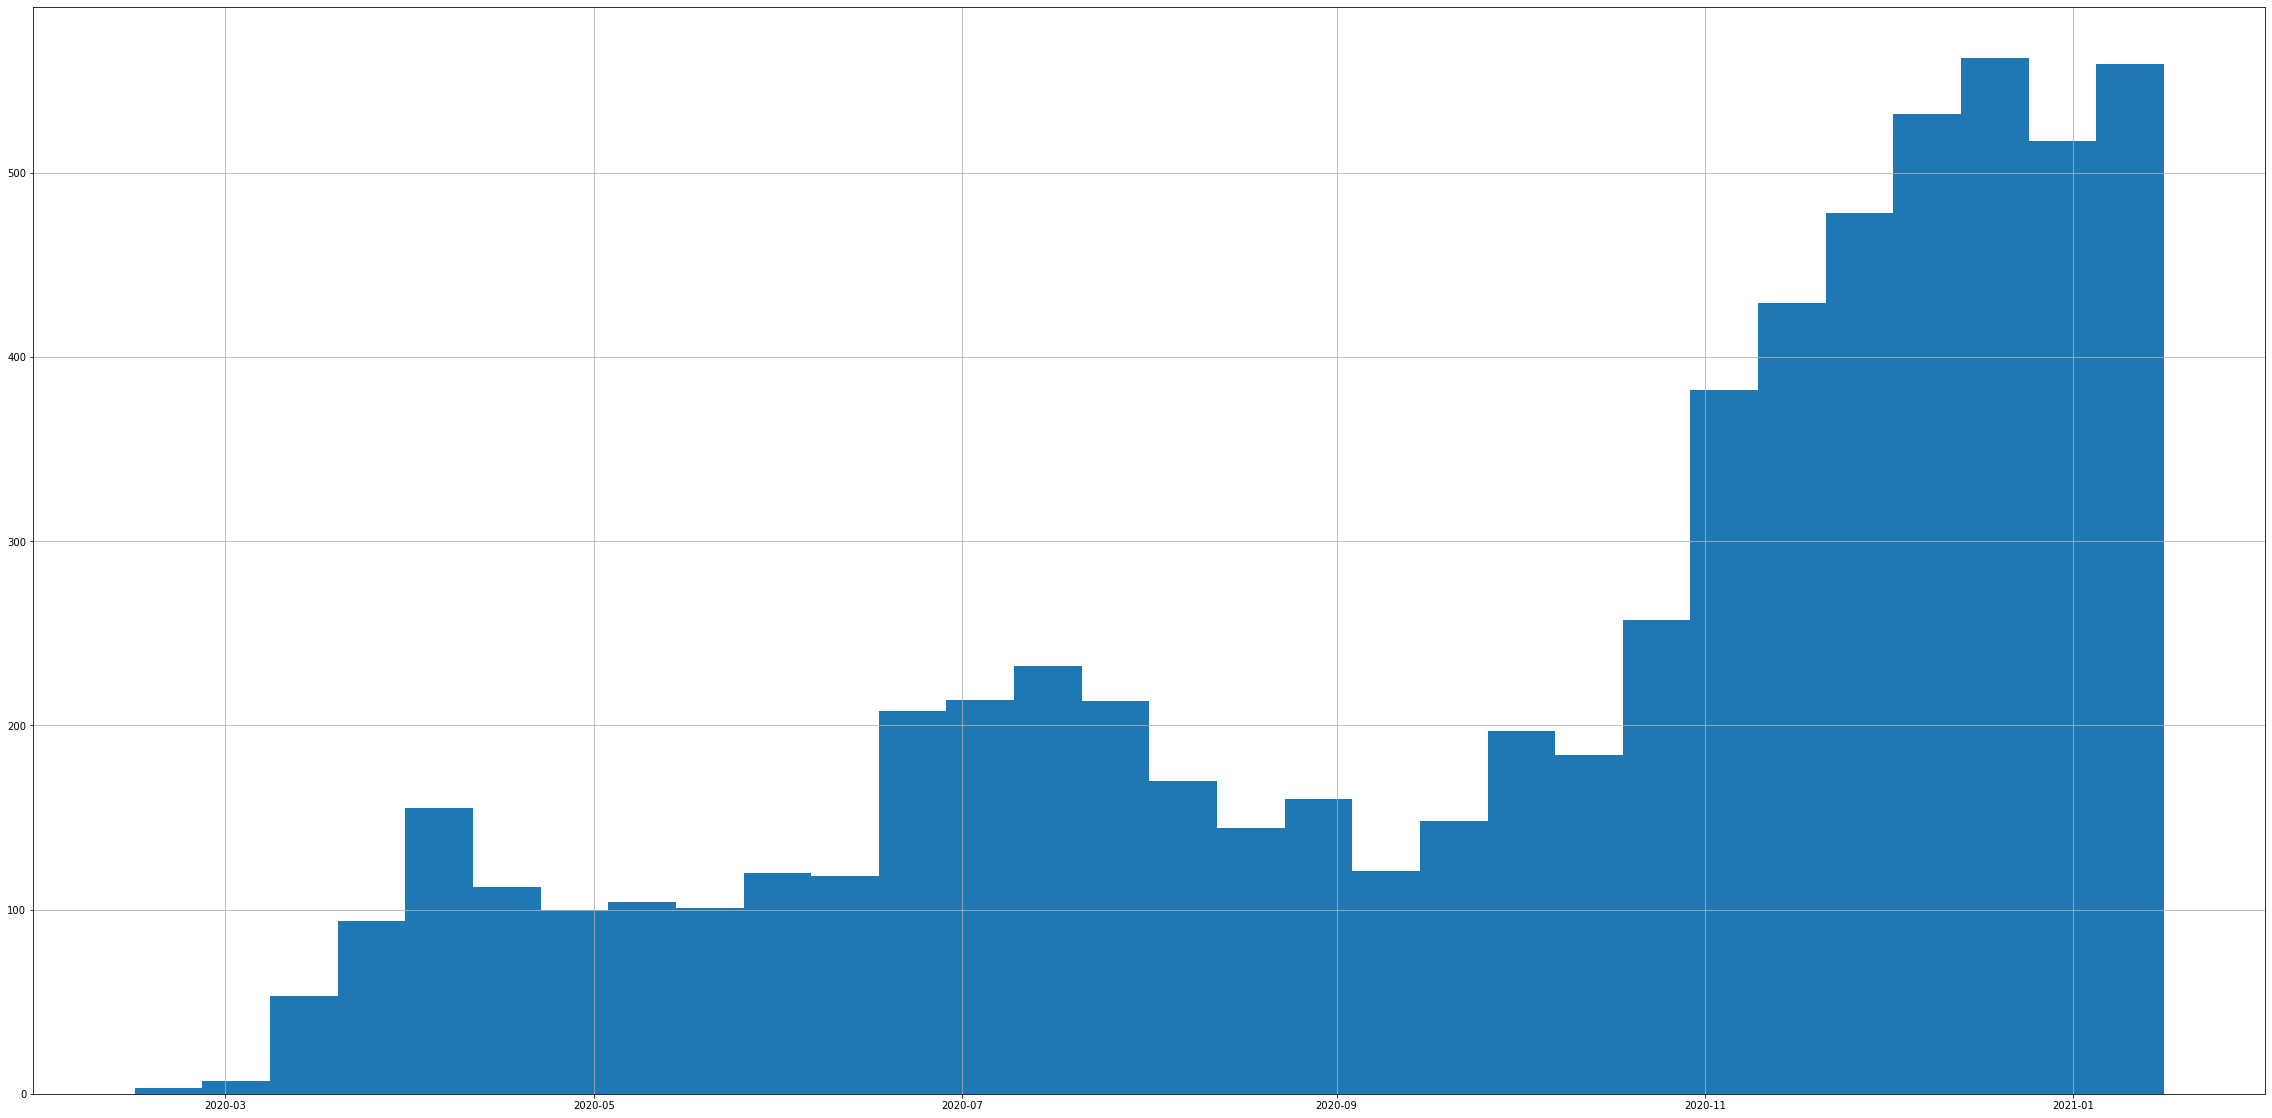

In [17]:
df_temp["cdc_case_earliest_dt"].hist(figsize=(40, 20), bins=30)

<AxesSubplot:title={'center':'%deaths_every_30days'}, xlabel='[death_yn]'>

<Figure size 432x288 with 0 Axes>

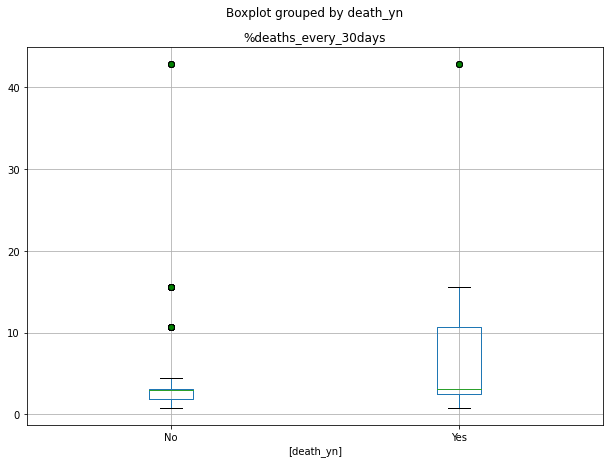

In [18]:
# Plot between '%deaths_every_30days' and target feature 'death_yn'.

plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6, linestyle='none')
df_temp.boxplot(['%deaths_every_30days'], by=['death_yn'], flierprops=flierprops, figsize=(10,7))

Text(0, 0.5, '% deaths')

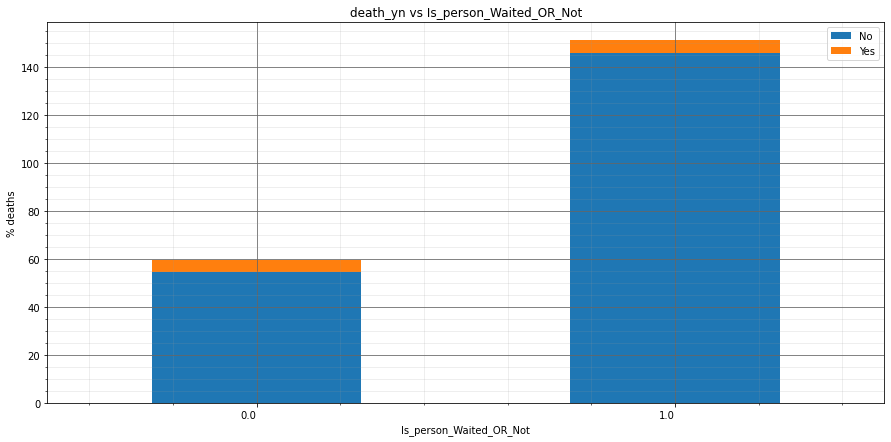

In [19]:
group = df_temp[['percent','Is_person_Waited_OR_Not','death_yn']].groupby(['Is_person_Waited_OR_Not','death_yn']).sum()

my_plot = group.unstack().plot(kind='bar', stacked=True, title="death_yn vs Is_person_Waited_OR_Not", figsize=(15,7), grid=True)

# add legend     
my_plot.legend(["No","Yes"])

# add gridlines
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xticks(rotation=0, ha='right')

my_plot.set_xlabel('Is_person_Waited_OR_Not')
my_plot.set_ylabel("% deaths")

From the above plots, we can observe that the interation between the target and these numerical features is quite good as there is some difference in the number of deaths which is expected as the dataset is imbalanced the deaths value should vary. Also, even the number of deaths are low, the percentage rate is high in every month. Due to which there is more percentage death rate shown in the above box plot. Furthermore, in general the percentage deaths are more when compared with other category which is as expected because during the initial days of covid there were more deaths in USA. 

On the other hand, the percentage of people who reacted fast are quite equal in both the categories of target feature. Hence this is also a good feature to have in the dataset as it is having some information which will be helpful for modelling.

Final continous features:
- %deaths_every_30days
- Is_person_Waited_OR_Not

Dropped continous features:
- cdc_case_earliest_dt

As it is having a datetime values in the dataset which is not acceptable for modelling. Also, the useful data from this date feature is extracted and created a new feature in the dataset. Due to which there is no use of having this feature for modelling. Hence this feature can be dropped. 

### 1.2.3 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature. 
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature...
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 9 categorical features
- A stacked bar plot for each will be created.


current_status
Index 	 Count
Laboratory-confirmed case 	 6241
Probable Case 	 433

sex
Index 	 Count
Female 	 3500
Male 	 3115
Unknown 	 58
Other 	 1

age_group
Index 	 Count
60 - 69 Years 	 716
80+ Years 	 308
70 - 79 Years 	 411
50 - 59 Years 	 987
30 - 39 Years 	 1059
20 - 29 Years 	 1248
0 - 9 Years 	 297
40 - 49 Years 	 937
10 - 19 Years 	 711

race_ethnicity_combined
Index 	 Count
White, Non-Hispanic 	 2253
Missing 	 2661
Hispanic/Latino 	 700
Black, Non-Hispanic 	 473
Asian, Non-Hispanic 	 182
Multiple/Other, Non-Hispanic 	 347
American Indian/Alaska Native, Non-Hispanic 	 44
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 14

hosp_yn
Index 	 Count
No 	 3581
Missing 	 2636
Yes 	 455
OTH 	 2

icu_yn
Index 	 Count
Missing 	 5952
No 	 669
Yes 	 53

death_yn
Index 	 Count

medcond_yn
Index 	 Count
Missing 	 5438
Yes 	 551
No 	 685

Seasons
Index 	 Count
Autumn 	 2132
Spring 	 792
Winter 	 2281
Summer 	 1469


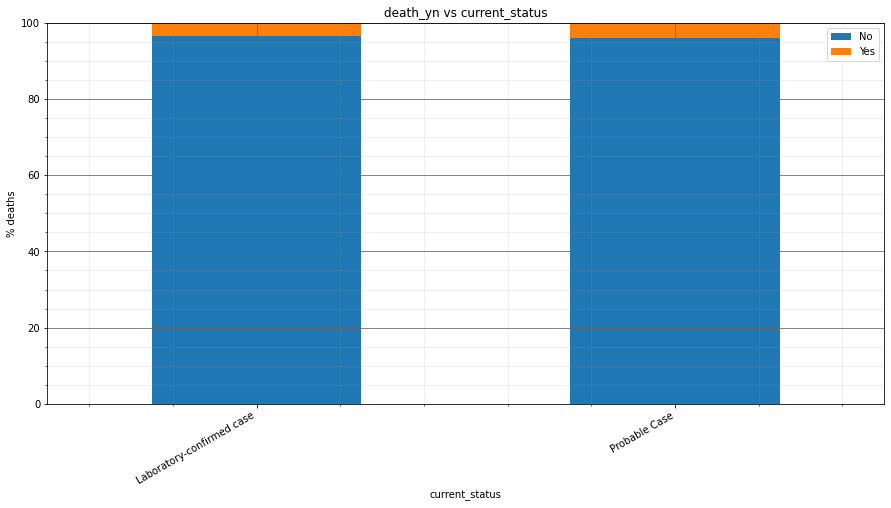

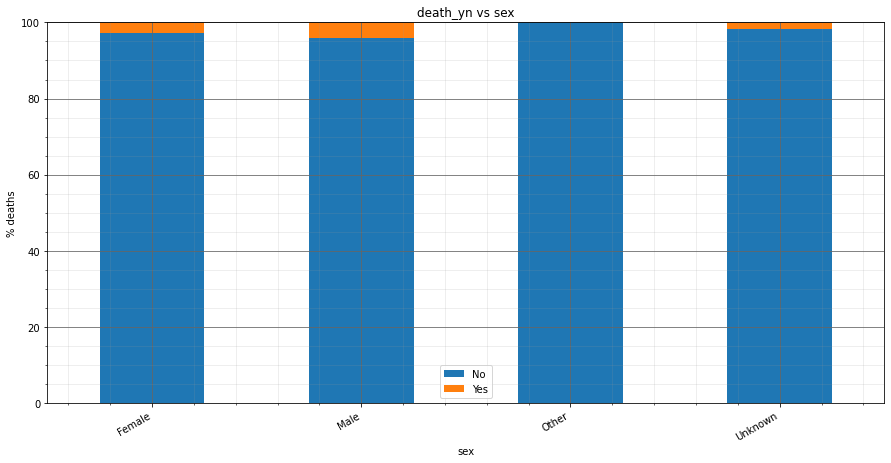

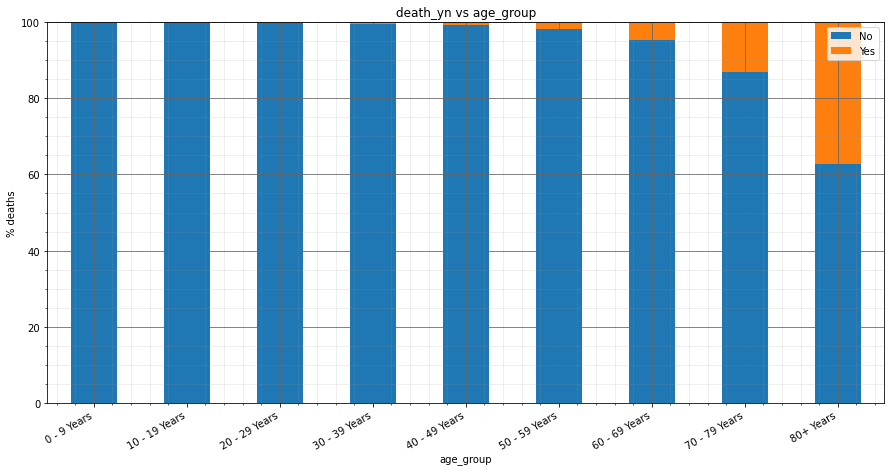

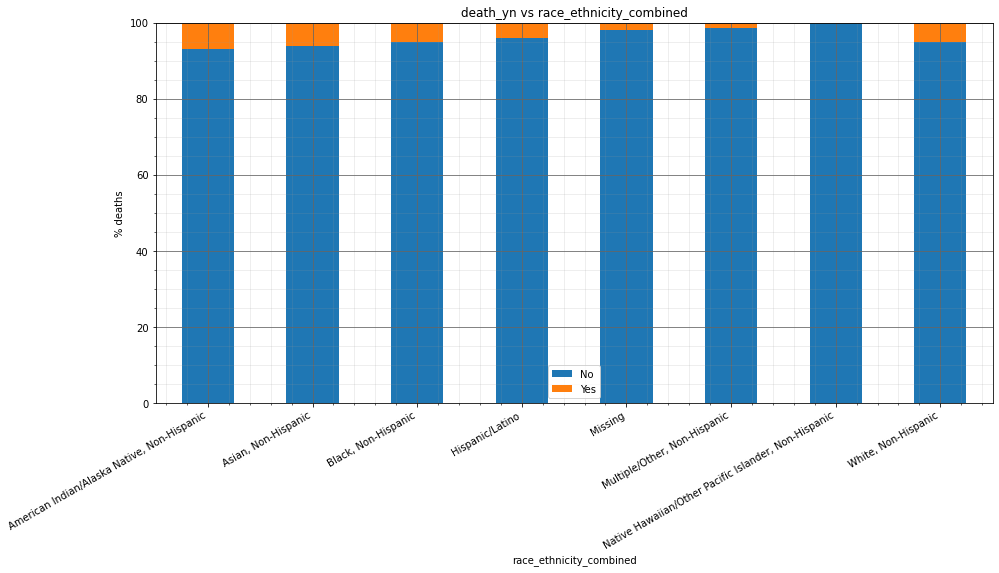

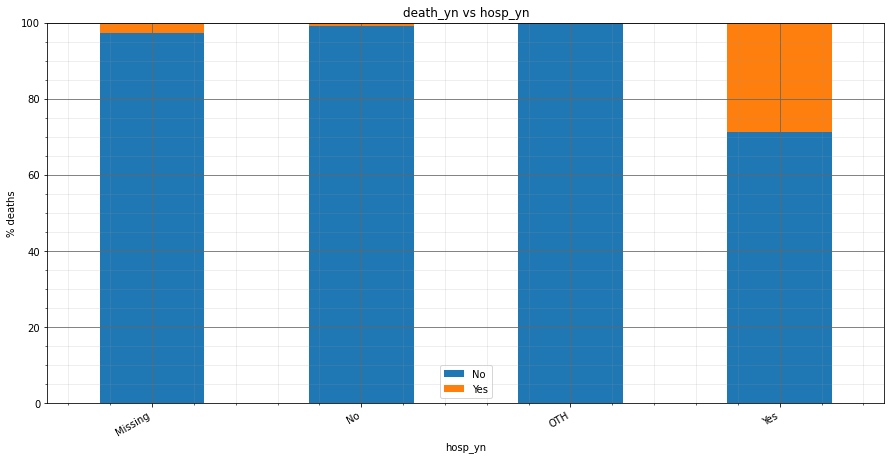

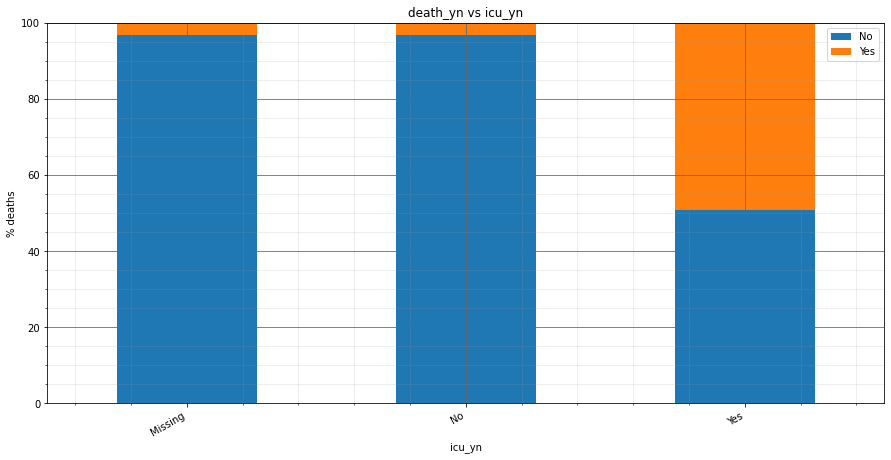

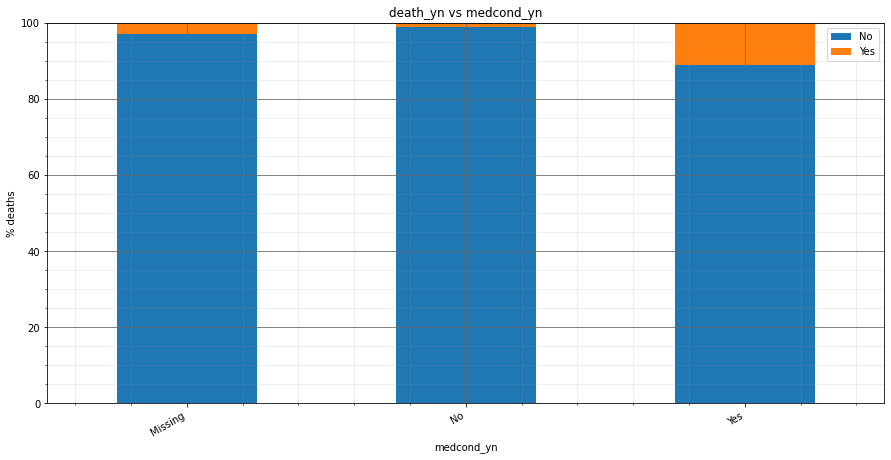

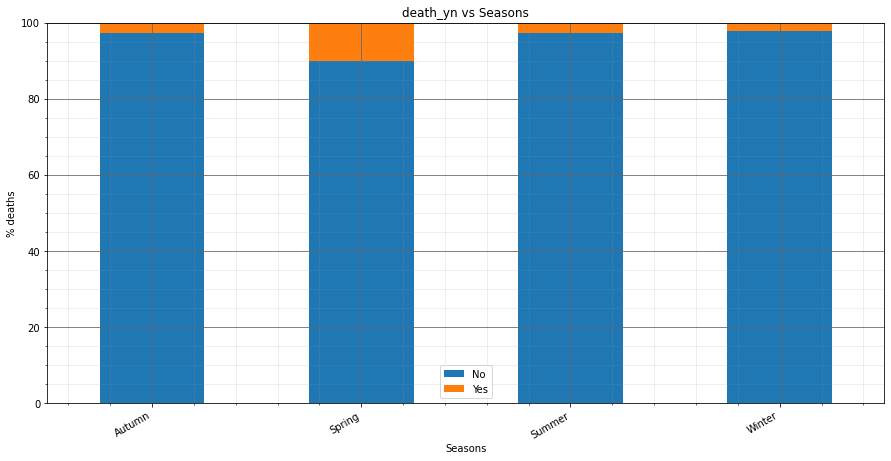

In [20]:
#Using code from the module lab

# to loop through all the features in categorical columns 
for second_feature in Category_features:
    details_of_feature = pd.unique(df_temp[second_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n" + '\033[1m' +second_feature+ '\033[0m')
    print("Index \t Count")
    
#  to avoid plotting between death_yn vs death_yn
    if('death_yn' != second_feature):
            

        # for each delinquency category
        for i in details_of_feature:

            count = df_temp[df_temp[second_feature] == i].count()['death_yn']
            count_percentage = (1 / count) * 100

            # print out index vs count
            print(i, "\t", count)

            index_list = df_temp[df_temp[second_feature] == i].index.tolist()
            for ind in index_list:
                df_temp.loc[ind, 'percent'] = count_percentage

        group = df_temp[['percent',second_feature,'death_yn']].groupby([second_feature,'death_yn']).sum()

        my_plot = group.unstack().plot(kind='bar', stacked=True, title="death_yn vs "+second_feature, figsize=(15,7), grid=True)

        # add legend     
        my_plot.legend(["No","Yes"])
        
        # add gridlines
        plt.grid(b=True, which='major', color='#666666', linestyle='-')
        plt.minorticks_on()
        plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        plt.xticks(rotation=30, ha='right')
        
        my_plot.set_xlabel(second_feature)
        my_plot.set_ylabel("% deaths")
        my_plot.set_ylim([0,100])
       
    else:
        continue
        
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

From the above stacked plots, we can observe that the current_status is not having a good relation with the target feature as the categories in this feature are having equal weight but according to the actual data the values are not same. Hence the stacked plot is contradicting the actual data and is not having any information. Hence this makes the prediction balanced and cannnot give a appropriate results. Therefore, this feature can be dropped from the dataset.


Final categorical feature selection :<br>
Except the current_status all other features seems to have a good relation with respect to target feature and hence lets keep all of them.

### 1.2.4 Summary & Drop Features

From the above analysis, we have decided to drop one categorical feature i.e. 'current_status'

In [21]:
# remove 'percent' feature that was used only for generating the stacked bar plot from the last homework. This should have been deleted in the last homework
df = df.drop("percent", 1)

In [22]:
# before dropping make copy of original
df_model = df.copy()
# drop low value features
df_model.drop('current_status', 1, inplace=True)
print('\nRemaining columns:', df_model.columns)
print('\nNew shape:', df_model.shape)


Remaining columns: Index(['cdc_case_earliest_dt', 'sex', 'age_group', 'race_ethnicity_combined',
       'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn', '%deaths_every_30days',
       'Seasons', 'Is_person_Waited_OR_Not'],
      dtype='object')

New shape: (9535, 11)


In [23]:
# The cdc_case_earliest_dt can be dropped from the dataframe as the datetime values are not accepted by the model. 
#Also, the information from this feature is extracted and created a new featuer which is in use.
# Hence drop this feature.

df_model = df_model.drop(['cdc_case_earliest_dt'],1)

In [24]:
df_model.head()

,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,%deaths_every_30days,Seasons,Is_person_Waited_OR_Not
0,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,2.955426,Winter,0.0
1,Female,10 - 19 Years,Missing,Missing,Missing,No,Missing,3.080569,Autumn,0.0
2,Female,30 - 39 Years,Missing,No,Missing,No,No,2.955426,Winter,1.0
3,Male,20 - 29 Years,"Black, Non-Hispanic",Missing,Missing,No,No,4.191617,Summer,1.0
4,Female,20 - 29 Years,Missing,No,Missing,No,Missing,2.955426,Winter,0.0


## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"

In [25]:
# set up dummies features
df_model = pd.get_dummies(df_model)
df_model.dtypes

%deaths_every_30days                                                            float64
Is_person_Waited_OR_Not                                                         float64
sex_Female                                                                        uint8
sex_Male                                                                          uint8
sex_Other                                                                         uint8
sex_Unknown                                                                       uint8
age_group_0 - 9 Years                                                             uint8
age_group_10 - 19 Years                                                           uint8
age_group_20 - 29 Years                                                           uint8
age_group_30 - 39 Years                                                           uint8
age_group_40 - 49 Years                                                           uint8
age_group_50 - 59 Years         

#### Remove redundant features
We do not need to keep 
'death_yn_No','sex_Unknown','age_group_80+Years','race_ethnicity_combined_Missing','hosp_yn_Missing','icu_yn_Missing','medcond_yn_Missing','Seasons_Winter'. 

The other columns of each category will tell whether this value is 1 or not. Hence these above columns does not required as the same information is extracted from other features of each category. Hence drop these features from the dataframe.

In [26]:
df_model = df_model.drop(['death_yn_No','sex_Unknown','age_group_80+ Years','race_ethnicity_combined_Missing','hosp_yn_Missing','icu_yn_Missing','medcond_yn_Missing','Seasons_Winter'],1)

#### Continuous columns are:

In [27]:
continuous_columns = df_model.select_dtypes(include=['float64']).columns.tolist()
continuous_columns

['%deaths_every_30days', 'Is_person_Waited_OR_Not']

In [28]:
categorical_columns = df_model.select_dtypes(include=['uint8']).columns.tolist()

# remove the target "death_yn_No"
categorical_columns.remove('death_yn_Yes')
categorical_columns

['sex_Female',
 'sex_Male',
 'sex_Other',
 'age_group_0 - 9 Years',
 'age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
 'race_ethnicity_combined_Asian, Non-Hispanic',
 'race_ethnicity_combined_Black, Non-Hispanic',
 'race_ethnicity_combined_Hispanic/Latino',
 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
 'race_ethnicity_combined_White, Non-Hispanic',
 'hosp_yn_No',
 'hosp_yn_OTH',
 'hosp_yn_Yes',
 'icu_yn_No',
 'icu_yn_Yes',
 'medcond_yn_No',
 'medcond_yn_Yes',
 'Seasons_Autumn',
 'Seasons_Spring',
 'Seasons_Summer']

#### Total features are:

In [29]:
features = continuous_columns + categorical_columns
features

['%deaths_every_30days',
 'Is_person_Waited_OR_Not',
 'sex_Female',
 'sex_Male',
 'sex_Other',
 'age_group_0 - 9 Years',
 'age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
 'race_ethnicity_combined_Asian, Non-Hispanic',
 'race_ethnicity_combined_Black, Non-Hispanic',
 'race_ethnicity_combined_Hispanic/Latino',
 'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
 'race_ethnicity_combined_White, Non-Hispanic',
 'hosp_yn_No',
 'hosp_yn_OTH',
 'hosp_yn_Yes',
 'icu_yn_No',
 'icu_yn_Yes',
 'medcond_yn_No',
 'medcond_yn_Yes',
 'Seasons_Autumn',
 'Seasons_Spring',
 'Seasons_Summer']

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [30]:
# y is the target
y = df_model["death_yn_Yes"]
# X is everything else
X = df_model.drop(["death_yn_Yes"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_model.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9535
training range (70%):	 rows 0 to 6674
test range (30%): 	 rows 6674 to 9535


In [31]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
       %deaths_every_30days  Is_person_Waited_OR_Not  sex_Female  sex_Male  \
724               2.305665                      0.0           1         0   
5118              4.460094                      0.0           1         0   
7756             15.555556                      1.0           1         0   
8398              0.822123                      0.0           0         1   
4594             15.555556                      1.0           0         1   

      sex_Other  age_group_0 - 9 Years  age_group_10 - 19 Years  \
724           0                      0                        0   
5118          0                      0                        0   
7756          0                      0                        0   
8398          0                      0                        0   
4594          0                      0                        0   

      age_group_20 - 29 Years  age_group_30 - 39 Years  \
724                         0                  

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [32]:
X_train.head(5)

,%deaths_every_30days,Is_person_Waited_OR_Not,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,hosp_yn_No,hosp_yn_OTH,hosp_yn_Yes,icu_yn_No,icu_yn_Yes,medcond_yn_No,medcond_yn_Yes,Seasons_Autumn,Seasons_Spring,Seasons_Summer
724,2.305665,0.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5118,4.460094,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
7756,15.555556,1.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
8398,0.822123,0.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4594,15.555556,1.0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0


We will now reset the index of all training and test dataframes

In [33]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,%deaths_every_30days,Is_person_Waited_OR_Not,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,hosp_yn_No,hosp_yn_OTH,hosp_yn_Yes,icu_yn_No,icu_yn_Yes,medcond_yn_No,medcond_yn_Yes,Seasons_Autumn,Seasons_Spring,Seasons_Summer
0,2.305665,0.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,4.460094,0.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,15.555556,1.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0.822123,0.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,15.555556,1.0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,1,0


The datasets are now ready for modeling

## (2) Linear Regression Model
#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

In [34]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model

In [35]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='ob

#### 2.3 Interpreting the linear regression model

- linear regression needs numeric features to predict on the new data. Due to which we have converted all the categorical feature to numeric values. 
- Also linear regression assumes a linear relationship between descriptive features and target feature. 
- In order to make the predictions, the weights of each each feature is required which will increase depending on the number of features. 
- After achieveing these values the prediction function will be 
  - $target\_value = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
  
- In this regression model, after training the model the intercept which we can observe above is 0.241
- The intercept value means that if the other feature values are then the target value will be 0.241. Also, means that the intercept touches the y-axis at 0.241.

- Here the coefficients are zipped and provided in a list for the ease of observation with its feature. Each feature coefficient is the weight of that feature in a target value equation.
- Furthermore, it is important to notice that the value of %death_every_30days feature is having a good impact on the model as the value provide that whether there are any deaths in a period of 30 days. 

When it comes to the robustness of the model, the linear regression cannot handle outliers as the linear slope equation may change inorder to get the model fit near to the outlier. Due to which the intercept and coefficients of other features change and this may lead to false outcomes.
But according our dataset there are no outliers in the data as most of them are categorical features. Also, the continous feature values are not exactly an outlier as that is a percentage of deaths in a month which can not be wrong data. Hence there are no outliers in the dataset.

It is important to note that the output from a linear regression model is not suited to the classification problem that we are trying to solve.
- The output is not a probability and an additional thresholding step is necessary to convert the output into a binary classification which is done in the next section


#### 2.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [36]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn_Yes  Predicted
0             0        0.0
1             1        0.0
2             0        0.0
3             0        0.0
4             0        0.0
5             0        0.0
6             0        0.0
7             0        0.0
8             0        0.0
9             1        0.0


From the above 10 predictions, we can observe that alomost every prediction seems correct with respect to the actual ones. This is beacuse the dataset is inbalanced as the number of deaths in the data are very less(about 3.1% in 6986 train set). 

But we will observe the actual measures among full training set in the next section.

#### 2.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [37]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.968684447108181
Confusion matrix: 
 [[6430   11]
 [ 198   35]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6441
           1       0.76      0.15      0.25       233

    accuracy                           0.97      6674
   macro avg       0.87      0.57      0.62      6674
weighted avg       0.96      0.97      0.96      6674



#### Interpretation of results:

- Confusion matrix:
    This matrix gives the details of actual values taken by the model and how many values are predicted out of it.
    This can be interpreted as TP(True Positive), TN(True Negative), FP(False Positive), FN(False Negative).
    
    TP - The value which is predicted 1 and the actual is also 1.
    TN - The value which is predicted is 0 and the actual is also 0.
    FP - The value which is predicted 1 and is actually 0.
    FN - The value which is predicted 0 and is actually 1.
    
    Here - 
           Actual No or TN - 6766
           Actual Yes or TP - 220

- Accuracy:
    - The overall accuracy on the train data is 97% which is quite good, but the dataset is imblanced so the accuracy is not a main focus here. 
    - As the majority class of the dataset is No(death_yn = NO). So the accuracy is quite good with respect to it.
- Precission:
    - This indicates what percentage of predicted positive are actually positive.
    - For class 0 i.e. death_yn = No. the precision is 0.97 which means that almost everything is predicted correctly.
    - On the other hand, for class 1 i.e. death_yn = Yes, the prediction positive is 0.72
- Recall:
    - This tells that how much percentage of positive values did the model predict.
    - Recall for the class positive i.e. a person died is 0.13
    - Recall for the class negative i.e. a person did not died is 1.00
    - The recall for class 0 is high because there are almost 97% of X-train is No(i.e. death_yn = No)
    
- f1-score
    - This is the weighted average of precision and recall.
    - The f1-score of negative class is 0.99
    - The f1-score of positive class is 0.22
    
Summary
- The model is  better at predicting the negative class.
- This makes sense as the model has more negative data to learn from - it is the majority class. 
- But with respect to the positive class, the model is not good as its recall value is low.
- Also, this is one of the reason that the positive class data is so great.

#### 2.6 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual death vs predicted based on test data

In [38]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   death_yn_Yes  Predicted
0             0        0.0
1             0        0.0
2             0        0.0
3             0        0.0
4             0        0.0
5             0        0.0
6             0        0.0
7             0        0.0
8             0        0.0
9             0        0.0


##### Evaluation metrics based on test data

In [39]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9713386927647676
Confusion matrix: 
 [[2762    7]
 [  75   17]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      2769
           1       0.71      0.18      0.29        92

    accuracy                           0.97      2861
   macro avg       0.84      0.59      0.64      2861
weighted avg       0.97      0.97      0.96      2861


==================== Train Data ======================
Accuracy:  0.968684447108181
Confusion matrix: 
 [[6430   11]
 [ 198   35]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6441
           1       0.76      0.15      0.25       233

    accuracy                           0.97      6674
   macro avg       0.87      0.57      0.62      6674
weighted avg       0.96      0.97      0.96      6674



**Interpretation of test results and comparison with training results**

- Confusion matrix
    - The test data has total values of 2994.
    - Out of which False positive values are 13 out of 92.
    
- Accuracy
    - The accuracy of the test data is reduced when compared with train data which are 96.8% and 97.1%. 
    - But overall these values are almost similar with a difference of 0.3%.
    
- Precision
    - The precision score for predicting the positive class has increased from 72% to 93%.
    - While the precision score for predicting the negative case remians same which is 97%.
    - The increase in precision is due to the predict positive values in test data is quite less when compared with train data. Due to which the numerator of the precision formula is high and thus overall percentage increases.
    
- Recall
    - The recall score for predicting the positive class has decreased from 13% to 12%.
    - The recall score for predicting the negative class reamins same which is 100%.
- F1
    - The f1 score for predicting the positive class remains same.
    - The f1 score for predicting the negative class has reduced from 99% to 98% which is equal with a little difference.

**Summary**
- These values are a little less than expected as we are now testing the model prediction on data it has not seen before
- More comparisons need to be made and this is where cross validation steps in

#### 2.7 Cross validation
- We will now perform cross validation on the linear regression model. 
- Here we perform the same evaluation as above but multiple times
- Each time the data is shuffled so we get a slightly different view of the data for training and testing
- This works well for evaluating on a limited set of data
- We will store the results in a dictionary for later use

First we need to create a function to perform this cross validation. Sklearn does not provide one for linear regression. However it does for logistic and random forests models
- Cross validation Function can be seen below

In [40]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [41]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [42]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.969696
precision,0.786084
recall,0.141094
f1,0.237153


From the above results, the values are almost equal with previous results. Here we have taken the mean of 10 sets of results. Even then the accuracy and recall is not changed as majority value of the dataset is having negative class. Alo, at each the set of values are different due to the random state but then the overall accuracy has same value beacuse the percentage of getting positive class values are very less as those are only 3%. 

## (3) Logistic Regression   

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above

In [43]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

#### 3.2 Print out the coefficients learned by the model

In [44]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='ob

#### 3.3 Interpreting the results 

The logistic regression function is a little different when compared with the linear regression function. 
- The output of the logistic function is a probability, a value between 0 and 1
- The output of the linear function is a continuous value that is not a probability
- Also, here it is not required to apply the threshold to this probability so that if it is >=0.5 its cast to 1 and if it os <0.5 it is casted to 0. These steps are taken out in the logistic regression as the sigmoid function will output a value between o and 1.
 

The model estimated in logistic regression is given by the logistic function: <br>
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$

- From the values above can see the calculated intercept is -2.453
    - This indicates that the if the values of other featurs are 0 then the value of the logistic regression is -2.453.
- We can see all the coefficients for each features
    - These are zipped together in a single list for ease of inspection.
    - The effect of these on the value 'x' is the same as for linear regression
  



In [45]:
# calculate the prediction value.
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   death_yn_Yes  Predicted
0             0          0
1             1          0
2             0          0
3             0          0
4             0          0
5             0          0
6             0          0
7             0          0
8             0          0
9             1          0


#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [46]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9710818100089901
Confusion matrix: 
 [[6410   31]
 [ 162   71]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.70      0.30      0.42       233

    accuracy                           0.97      6674
   macro avg       0.84      0.65      0.70      6674
weighted avg       0.97      0.97      0.97      6674



#### Interpretation of results:

- Confusion matrix:
    This matrix gives the details of actual values taken by the model and how many values are predicted out of it.
    This can be interpreted as TP(True Positive), TN(True Negative), FP(False Positive), FN(False Negative).
    
    TP - The value which is predicted 1 and the actual is also 1.
    TN - The value which is predicted is 0 and the actual is also 0.
    FP - The value which is predicted 1 and is actually 0.
    FN - The value which is predicted 0 and is actually 1.
    
    Here - 
           Actual No or TN - 6766
           Actual Yes or TP - 220

- Accuracy:
    - The overall accuracy on the train data is 97.3% which is quite good, but the dataset is imblanced so the accuracy is not a main focus here. 
    - As the majority class of the dataset is No(death_yn = NO). So the accuracy is quite good with respect to it.
- Precission:
    - This indicates what percentage of predicted positive are actually positive.
    - For class 0 i.e. death_yn = No. the precision is 0.98.
    - On the other hand, for class 1 i.e. death_yn = Yes, the prediction positive is 0.32
- Recall:
    - This tells that how much percentage of positive values did the model predict.
    - Recall for the class positive i.e. a person died is 0.32
    - Recall for the class negative i.e. a person did not died is 0.99
    - The recall for class 0 is high because there are almost 97% of X-train is No(i.e. death_yn = No)
    
- f1-score
    - This is the weighted average of precision and recall.
    - The f1-score of negative class is 0.99
    - The f1-score of positive class is 0.43
    
Summary
- The model is also better at predicting the negative class.
- This makes sense as the model has more negative data to learn from - it is the majority class. 
- But with respect to the positive class, the model is not good as its recall value is low.
- Also, this is one of the reason that the positive class data is so great.

#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [47]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          0
1              0          0
2              0          0
3              0          0
4              0          0
5              0          0
6              0          0
7              0          0
8              0          0
9              0          0
10             0          0
11             0          0
12             0          0
13             0          0
14             0          0
15             0          0
16             0          0
17             0          0
18             0          0
19             0          0


Evaluation based on test data

In [48]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9699405802167075
Confusion matrix: 
 [[2746   23]
 [  63   29]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2769
           1       0.56      0.32      0.40        92

    accuracy                           0.97      2861
   macro avg       0.77      0.65      0.69      2861
weighted avg       0.96      0.97      0.97      2861

==================== Train Data =======================
Accuracy:  0.9710818100089901
Confusion matrix: 
 [[6410   31]
 [ 162   71]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.70      0.30      0.42       233

    accuracy                           0.97      6674
   macro avg       0.84      0.65      0.70      6674
weighted avg       0.97      0.97      0.97      6674



**Interpretation of test results and comparison with training results**

- Confusion matrix
    - The test data has total values of 2994.
    - Here 25% of the postive class values are predicted correctly which is good.
- Accuracy
    - The accuracy of the test data is reduced when compared with train data. These values are 97.3% and 96.9%. 
    - But overall these values are almost similar with a difference of 0.4%.
    
- Precision
    - The precision score for predicting the positive class has reduced from 67% to 26%.
    - While the precision score for predicting the negative has increased from 99% to 100%.
    
- Recall
    - The recall score for predicting the positive class has decreased from 32% to 12%.
    - The recall score for predicting the negative class reamins same which is 100%.
- F1
    - The f1 score for predicting the positive class has reduced from 43% to 37%.
    - The f1 score for predicting the negative class has reduced from 99% to 98% which is equal with a little difference.

**Summary**
- These are almost same with linear regression results.
- But the prediction results for positive class in logistic regression is high when compared with linear regression.
- These values are a little less than expected as we are now testing the model prediction on data it has not seen before
- More comparisons need to be made and this is where cross validation steps in

#### 3.7 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [49]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [50]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.970110
precision,0.627805
recall,0.301042
f1,0.404898


From the above results, we can observe that the accuracy approximately remains near to the test data. But when compared with respect to the recall this value is bit high which is good that the model is generalising. 

Hence the logistic regression is better than linear regression but we cannot conclude until the final predictions on other models. Hence we look into reandom forest in the next section.

## (4) Random Forest Model

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated

In [51]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 4.2 Understanding the Random Forest model

- We will first start by trying to understand a decision tree 
- A random forest is made up of an ensemble/collection of decision trees
- Decision tree
    - A decision tree is a set of if-then-else rules based on splitting the data based on specific features
    - The decision on which feature to split on is based on the information gain (Gini index). 
   
- Random Forest 
    - The random forest is made up of a number of decision trees
    - The output of the random forest is base on the majority output of all decision trees combined
    - This gives reliable results but can be hard to interpret
    - The random forest will keep track of the importance of features in terms of information gain, which we will see
    
We will now look at an example of a single decision tree to get a better understanding

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=9
- Max depth determines how deep a decision tree can go before it must give an answer

In [52]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc9 = DecisionTreeClassifier(max_depth=9, random_state=1)
dtc4.fit(X_train, y_train)
dtc9.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc9)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=9, random_state=1)


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [53]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc9, out_file=f2, feature_names=X_train.columns)


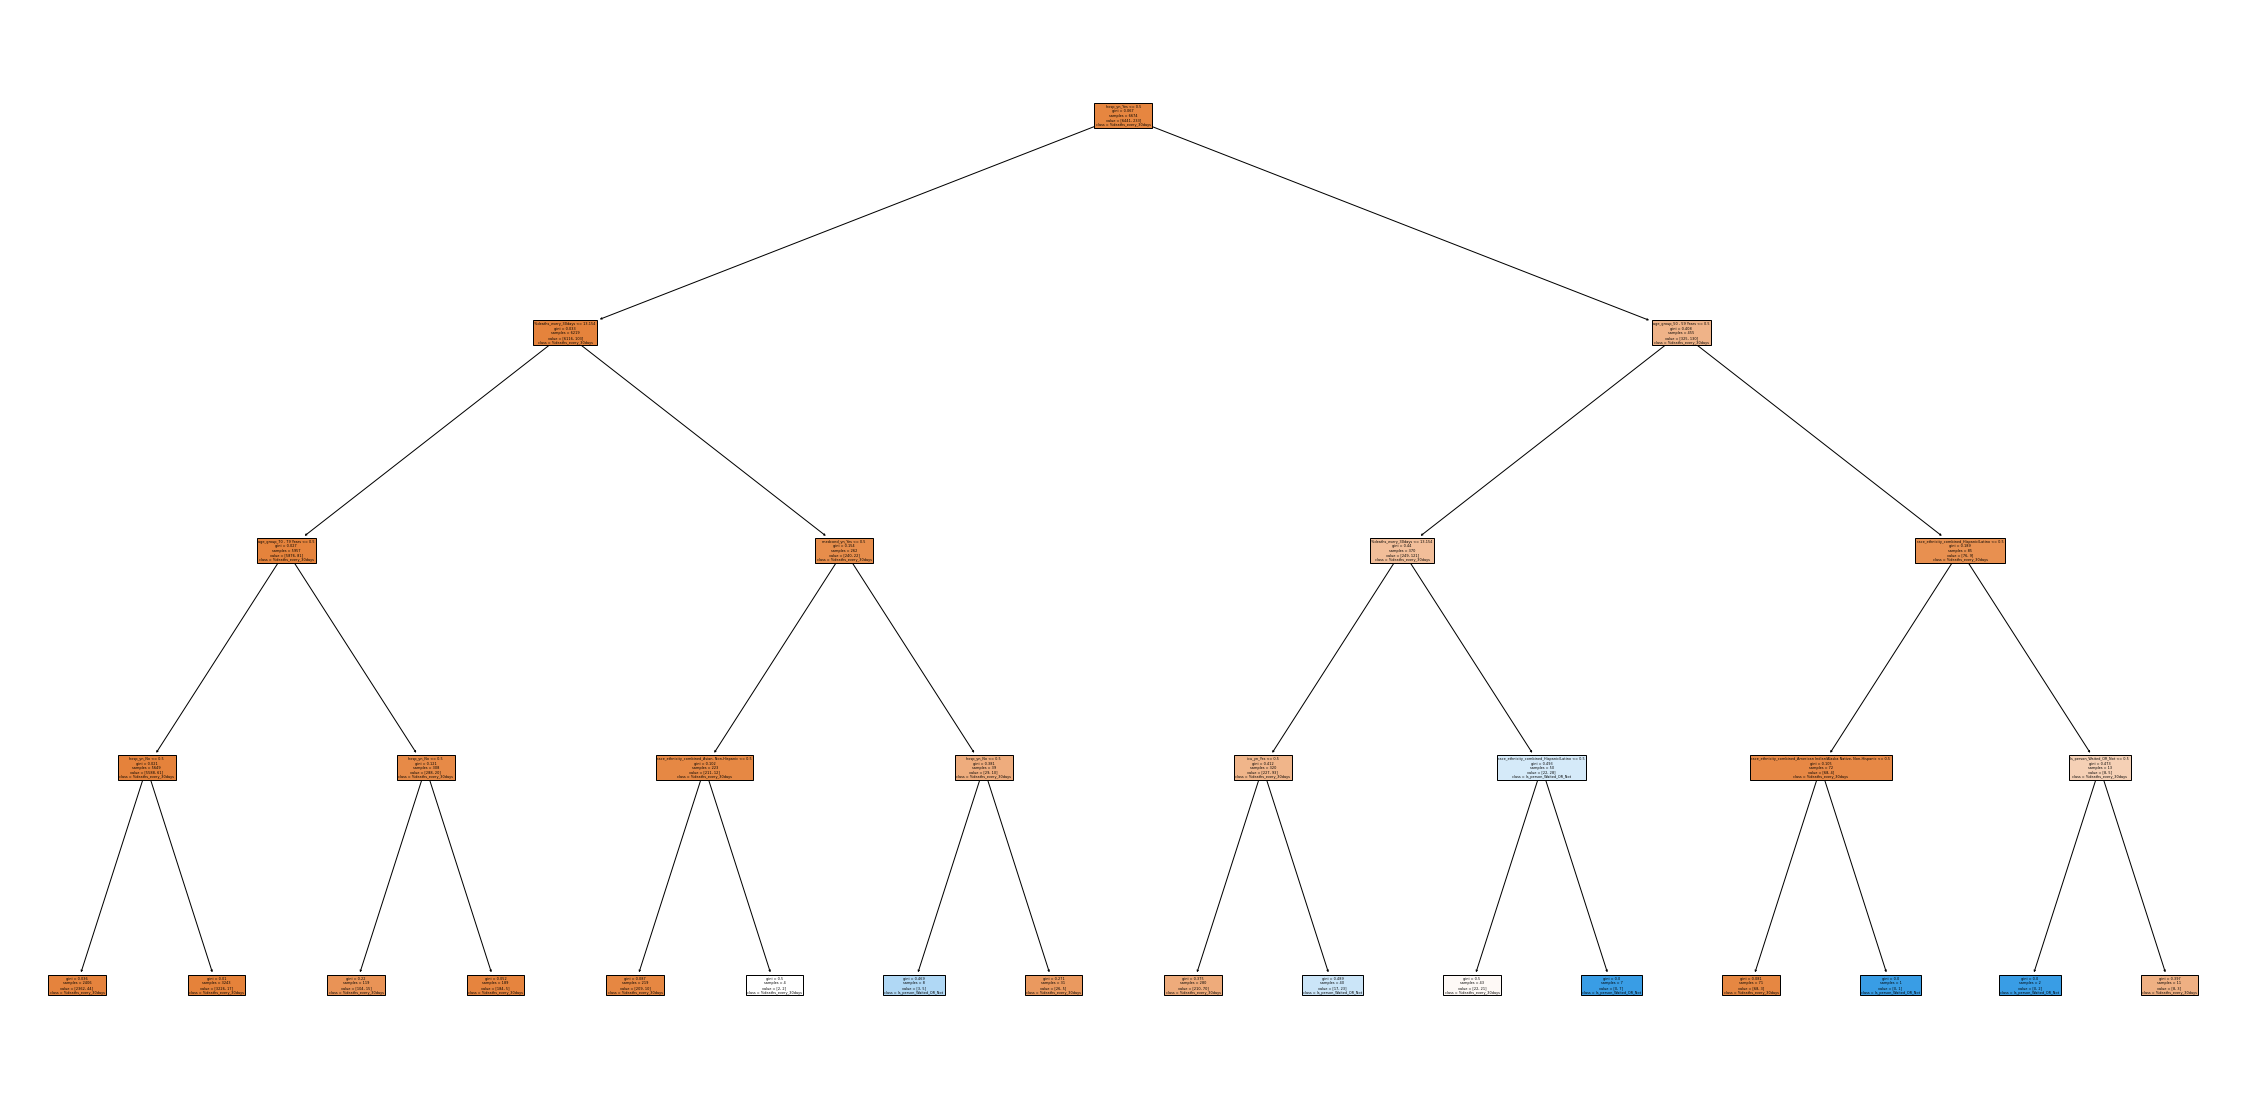

In [54]:
fig = plt.figure(figsize=(40,20))
Tree_Depth_4 = tree.plot_tree(dtc4, feature_names=X_train.columns,  class_names=X_train.columns, filled=True)

fig.savefig("decistion_tree4.png")

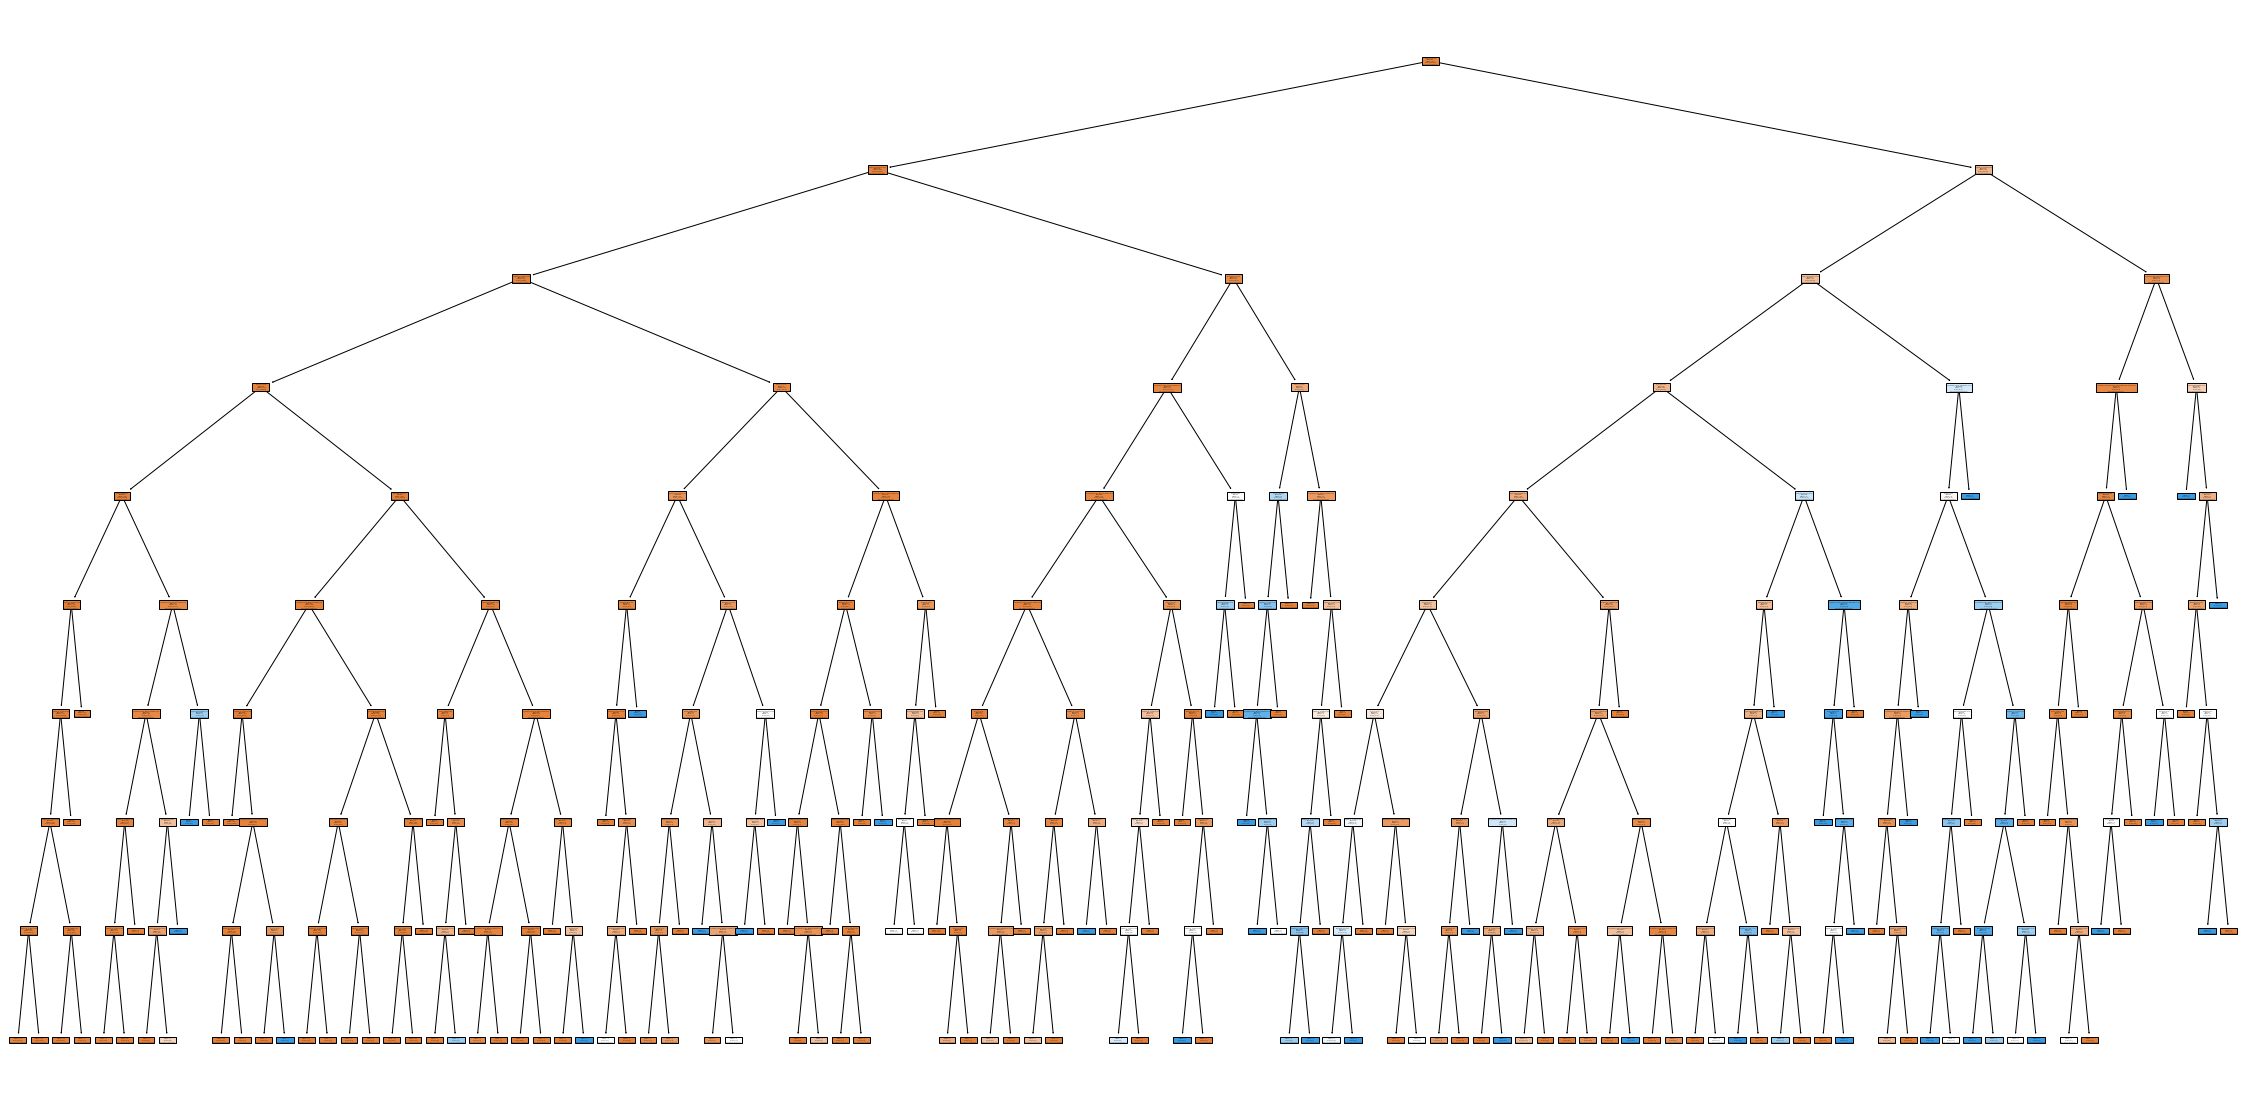

In [55]:
fig = plt.figure(figsize=(40,20))
Tree_Depth_9 = tree.plot_tree(dtc9, feature_names=X_train.columns,  class_names=X_train.columns, filled=True)

fig.savefig("decistion_tree9.png")

The color coding in the above graphs indicates the majority of the class.

As we have 9 features in the dataset, the decision tree is trained with the depth of 4 and 9 to see how the branches are formed with total features. As we can observe in the figure of depth= 4, the majority of the branchaes are formed based on the '%death_every_30days' which indicates that this feature is so informative.

Also, these are the sample decision trees which are similar to the actual ones.
But in real case there will be 100's of similar tress which are constructed and at each of the tree the output is noted. Then the mean value among these output values are taken as the final result and are displayed as in the further sections.

#### 4.2.3 Interpretation of the random forest model
As mentioned above the random forest will keep track of the importance of features
- We can see from the dataframe below the results of this feature importance ranking
- The more important features are the features that the random forest has identified as having higher information gain
- This list is the combined result of the 100 decision trees that make up the random forest model

Furthermore, we can observe that the new features which are created in the data cleaning dataset(which is done in another file as mentioned above) are having **high information** and are taken as top priority among all other in th table below.
Among the 3 new feature the '%deaths_every_30days' and 'Is_person_Waited_OR_Not' are having very good information in predicting the target feature. While 'Seasons' feature is also having some information but which is not as the above 2 features.

In [56]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
0,%deaths_every_30days,0.140650
22,hosp_yn_Yes,0.110025
1,Is_person_Waited_OR_Not,0.058158
11,age_group_60 - 69 Years,0.050898
19,"race_ethnicity_combined_White, Non-Hispanic",0.050541
10,age_group_50 - 59 Years,0.048504
26,medcond_yn_Yes,0.044805
12,age_group_70 - 79 Years,0.041955
24,icu_yn_Yes,0.037290
20,hosp_yn_No,0.035847


This information gain is a good feature to the random forest which tells what all features are providing good information in predicting the target feature. 

From the list of features, the features are sorted from the top information given feature till the least one. So, as we can observe that the other category in sex, other in hospital status features are providng very information to the target feature. 

### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 10 training examples. 

In [57]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,1,1


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [58]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9928079112975726
Confusion matrix: 
 [[6433    8]
 [  40  193]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00      6441
           1       0.96      0.83      0.89       233

    accuracy                           0.99      6674
   macro avg       0.98      0.91      0.94      6674
weighted avg       0.99      0.99      0.99      6674



### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual RiskPerformance vs predicted based on test data

In [59]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


Evaluation metrics based on test data

In [60]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9629500174764068
Confusion matrix: 
 [[2731   38]
 [  68   24]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2769
           1       0.39      0.26      0.31        92

    accuracy                           0.96      2861
   macro avg       0.68      0.62      0.65      2861
weighted avg       0.96      0.96      0.96      2861

==================== Train Data =======================
Accuracy:  0.9928079112975726
Confusion matrix: 
 [[6433    8]
 [  40  193]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      1.00      6441
           1       0.96      0.83      0.89       233

    accuracy                           0.99      6674
   macro avg       0.98      0.91      0.94      6674
weighted avg       0.99      0.99      0.99      6674



**Interpretation of test results and comparison with training results**

- Confusion matrix
    - The test data has total values of 2994.
    - Here 22% of the postive class values are predicted correctly.
- Accuracy
    - The accuracy of the test data is reduced when compared with train data. The values are 99.1% and 96.5%. 
    - The difference between these results are having a great difference.
    
- Precision
    - The precision score for predicting the positive class has reduced from 94% to 51%.
    - While the precision score for predicting the negative has reduced from 99% to 97%.
    
- Recall
    - The recall score for predicting the positive class has decreased from 78% to 23%.
    - The recall score for predicting the negative class has reduced from 100% to 99%.
- F1
    - The f1 score for predicting the positive class has reduced from 85% to 32%.
    - The f1 score for predicting the negative class has reduced from 100% to 98% which is equal with a little difference.

**Summary**
- The results are having a large differnece when compared with other 2 models.
- These values are a little less than expected as we are now testing the model prediction on data it has not seen before
- More comparisons need to be made and this is where cross validation steps in

### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [61]:
def cross_val_RandomForest_DF(X,y, depth=None, trees=50):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=trees, max_features='auto',  oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [62]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.963398
precision,0.442984
recall,0.248958
f1,0.315725


- The accuracy has been dropped from other 2 models and is having same accuracy before cross-validation. Which is beacuse even after 10 fold cross validation the set is not having good rows of positive class due to which the negative class is a majority class and hence the values are not appropriate.

- While the precision, recall, f1 are decreased with train data but almost similar with other results. 

## 5 Improving Predictive Models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 

#### 5.1.1 Comparision between all the models
- All models preform almost identical on the test dataset except with random forest which is having a difference of - 1%
- Summary of the results so far can be seen below (based on predicting as person died=Yes)


In [63]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.969696,0.970110,0.963398
precision,0.786084,0.627805,0.442984
recall,0.141094,0.301042,0.248958
f1,0.237153,0.404898,0.315725


From the comparision of above 3 models, we can conclude that the
- logistic regression is performing well in predicting the postive class(death_yn = Yes) which can be observed in recall.
- With respect to the accuracy also, the logistic regression is good but here the most of the values(majority class) are death_yn = No.

Hence, overall the **logistic regression** is the best model among all 3 models.

### 5.1.2 Is the model more accurate than a simple model that always predicts the majority class
- We will compare our results above to a simple model which predicts for the majority class
- First we will get the breakdown of the test dataset and see which is the majority class

In [64]:
death_yes_count = y_test[y_test == 1].count()
death_No_count = y_test[y_test == 0].count()
total = death_yes_count+ death_No_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number of persons never dead:\t {death_yes_count}\t{round(death_yes_count/len(y_test)*100,2)}%')
print(f'Total number of persons died:\t\t {death_No_count}\t{round(death_No_count/len(y_test)*100,2)}%')

From original dataset: 		Count 2861
Total number of persons never dead:	 92	3.22%
Total number of persons died:		 2769	96.78%


In [65]:
# generate array of 2994 zeros (length of test dataset)
majority = np.zeros(2861)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.9678434113946173
Confusion matrix: 
 [[2769    0]
 [  92    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2769
           1       0.00      0.00      0.00        92

    accuracy                           0.97      2861
   macro avg       0.48      0.50      0.49      2861
weighted avg       0.94      0.97      0.95      2861



### 5.2 Summarise your understanding of the problem and results. Can you think of ideas in improving the best model so far.

- For predicting good outcome the simple model fails completely as expected
- In predicting the final target feature, the simple model is much worse than other models which can be observed from above results
    - The precision is the same as the accuracy in this case - i.e. how good is it at predicting 0
    - The recall is 100% as all of the actual 0 values were predicted 0, but the value is 0 for positive class.
    - The f1 is between the precision and recall as it is a weighted average of the two

As, we know that the dataset is imbalanced the low results of the models are expected. Also, there are many other parameters which effect the target feature which are not considered. But with this dataset, it is tough to conclude the results with such low data for death = Yes. Neverthless, with the existing data the below are the final conclusions till now on the modelling.

Therefore, 
- From the above results and comparisions, the logistic regression is the best model to predict the target feature,
- Logistic regression is better in accuracy, recall(as it is important with respect to positive class).
- Also, it is more robust to outliers, hence the results does not effect even with different set of data which is having outliers.
- The simple model concludes that the dataset is imbalanced due to which the prediction results not appropriate.

#### Ideas to improve the model results
- 5.2.1 By **normalising** the continous features.
    - Sometimes the model may give good results on predictiong the target feature by normalising the data. 
    - Hence here the only continous feature '%deaths_every_30days' is normalised and then compared the results
    
- 5.2.2 **Balance the dataset** by replacing some rows with death_yn = Yes.
    - As the dataset is imbalanced, we will change some data to death_yn = yes and check the output of the model.

### 5.2.1 Normalising continous data
We will use the standard normalise for the continous feature and test the results. Because the tarnsformation of standardising is very common and can help some learning algorithms.

In [66]:
# We will use the new dataframe which is a copy of df_model consists of all feature with dummy encoding
df_norm = df_model.copy()

In [67]:
#Only keep numeric features
df_cont = df['%deaths_every_30days']

In [68]:
# Standardise all numeric columns and store in the same dataset
df_norm['%deaths_every_30days'] = (df_cont - df_cont.mean()) / df_cont.std()
df_norm

,%deaths_every_30days,Is_person_Waited_OR_Not,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,hosp_yn_OTH,hosp_yn_Yes,icu_yn_No,icu_yn_Yes,death_yn_Yes,medcond_yn_No,medcond_yn_Yes,Seasons_Autumn,Seasons_Spring,Seasons_Summer
0,-0.134278,0.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.097189,0.0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-0.134278,1.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0.232097,1.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
4,-0.134278,0.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9530,-0.097189,1.0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
9531,-0.766533,0.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9532,-0.766533,1.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9533,-0.097189,1.0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [69]:
# y is the target
y_norm = df_norm["death_yn_Yes"]
# X is everything else
X_norm = df_norm.drop(["death_yn_Yes"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, random_state=1,  test_size=0.3)

print("original range is: ",df_model.shape[0])
print("training range (70%):\t rows 0 to", round(X_train_norm.shape[0]))
print("test range (30%): \t rows", round(X_train_norm.shape[0]), "to", round(X_train_norm.shape[0]) + X_test_norm.shape[0])

original range is:  9535
training range (70%):	 rows 0 to 6674
test range (30%): 	 rows 6674 to 9535


In [70]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train_norm.reset_index(drop=True, inplace=True)
y_train_norm.reset_index(drop=True, inplace=True)
X_test_norm.reset_index(drop=True, inplace=True)
y_test_norm.reset_index(drop=True, inplace=True)

In [71]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg_norm = LogisticRegression().fit(X_train_norm, y_train_norm)

In [72]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train_norm.columns)
print("\nCoeficients are: \n", multiple_logisticreg_norm.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg_norm.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train_norm.columns, multiple_logisticreg_norm.coef_[0])))


Features are: 
 Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='ob

In [73]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train_norm = multiple_logisticreg_norm.predict(X_train_norm)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_norm = pd.concat([y_train_norm, pd.DataFrame(multiple_logisticreg_predictions_train_norm, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_norm.head(100))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          0
1              1          0
2              0          0
3              0          0
4              0          0
..           ...        ...
95             0          0
96             0          0
97             0          0
98             0          0
99             1          1

[100 rows x 2 columns]


In [74]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("Classification report:\n ", metrics.classification_report(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9710818100089901
Confusion matrix: 
 [[6410   31]
 [ 162   71]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.70      0.30      0.42       233

    accuracy                           0.97      6674
   macro avg       0.84      0.65      0.70      6674
weighted avg       0.97      0.97      0.97      6674



In [75]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test_norm = multiple_logisticreg_norm.predict(X_test_norm)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_norm = pd.concat([y_test_norm, pd.DataFrame(multiple_logisticreg_predictions_test_norm, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_norm.head(20))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          0
1              0          0
2              0          0
3              0          0
4              0          0
5              0          0
6              0          0
7              0          0
8              0          0
9              0          0
10             0          0
11             0          0
12             0          0
13             0          0
14             0          0
15             0          0
16             0          0
17             0          0
18             0          0
19             0          0


In [76]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test_norm, multiple_logisticreg_predictions_test_norm))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test_norm, multiple_logisticreg_predictions_test_norm))
print("Classification report:\n ", metrics.classification_report(y_test_norm, multiple_logisticreg_predictions_test_norm))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("Classification report:\n ", metrics.classification_report(y_train_norm, multiple_logisticreg_predictions_train_norm))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9699405802167075
Confusion matrix: 
 [[2746   23]
 [  63   29]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2769
           1       0.56      0.32      0.40        92

    accuracy                           0.97      2861
   macro avg       0.77      0.65      0.69      2861
weighted avg       0.96      0.97      0.97      2861

==================== Train Data =======================
Accuracy:  0.9710818100089901
Confusion matrix: 
 [[6410   31]
 [ 162   71]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.70      0.30      0.42       233

    accuracy                           0.97      6674
   macro avg       0.84      0.65      0.70      6674
weighted avg       0.97      0.97      0.97      6674



In [77]:
def cross_val_LogReg_DF_norm(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults_norm = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults_norm[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults_norm, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

In [78]:
logRegDF_norm = cross_val_LogReg_DF_norm(X_norm,y_norm)
print(f"Mean results from 10 fold cross validation are:")
logRegDF_norm

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.970110
precision,0.627805
recall,0.301042
f1,0.404898


From the above results, we can observe that the accuracy, recall does not have any change from the previous model by normalising the continous feature. Hence normalisation does not effect the predictions.

### 5.2.2. Balance the dataset.

Here we randomly change the value of traget feature by selecting a range of values. There are 5000 values which will be changed using the index values of randomly selected rows. <br>

Then this clearles the problem of imbalanced data. But this data is not sufficient to train the model as the number of combinations of features to the target value will be resuced. But we can not conclude the results and hence we will implement the model on balanced dataset and compare the results.

In [79]:
# Make a copy of original data and resample the values
df_balanced = df.copy()

In [80]:
# select 5000 rows from the dataset and update the target value with yes. then set them back to the original set.
dfupdate=df_balanced.sample(5000)
dfupdate.death_yn='Yes'
df_balanced.update(dfupdate)
update_list = dfupdate.index.tolist() # from  cᴏʟᴅsᴘᴇᴇᴅ  :)
df_balanced

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,%deaths_every_30days,Seasons,Is_person_Waited_OR_Not
0,2020-12-01,Laboratory-confirmed case,Male,30 - 39 Years,"White, Non-Hispanic",Missing,Missing,No,Missing,2.955426,Winter,0.0
1,2020-10-28,Laboratory-confirmed case,Female,10 - 19 Years,Missing,Missing,Missing,No,Missing,3.080569,Autumn,0.0
2,2020-12-28,Laboratory-confirmed case,Female,30 - 39 Years,Missing,No,Missing,No,No,2.955426,Winter,1.0
3,2020-07-28,Laboratory-confirmed case,Male,20 - 29 Years,"Black, Non-Hispanic",Missing,Missing,Yes,No,4.191617,Summer,1.0
4,2020-12-02,Laboratory-confirmed case,Female,20 - 29 Years,Missing,No,Missing,No,Missing,2.955426,Winter,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9530,2020-10-04,Laboratory-confirmed case,Female,20 - 29 Years,"White, Non-Hispanic",No,Missing,Yes,Missing,3.080569,Autumn,1.0
9531,2021-01-16,Laboratory-confirmed case,Male,40 - 49 Years,Missing,Missing,Missing,No,Missing,0.822123,Winter,0.0
9532,2021-01-11,Laboratory-confirmed case,Male,40 - 49 Years,Missing,No,Missing,No,Missing,0.822123,Winter,1.0
9533,2020-10-02,Laboratory-confirmed case,Male,40 - 49 Years,"Asian, Non-Hispanic",Missing,Missing,No,Missing,3.080569,Autumn,1.0


In [81]:
# Here we can observe there are 5000 rows of positive class
df_balanced[(df_balanced.death_yn == 'Yes')].shape

(5163, 12)

In [82]:
# drop these 2 features which are not required for modelling.
df_balanced = df_balanced.drop(['cdc_case_earliest_dt','current_status'],1)

In [83]:
# set up dummies features
df_balanced = pd.get_dummies(df_balanced)
df_balanced.dtypes

%deaths_every_30days                                                            float64
Is_person_Waited_OR_Not                                                         float64
sex_Female                                                                        uint8
sex_Male                                                                          uint8
sex_Other                                                                         uint8
sex_Unknown                                                                       uint8
age_group_0 - 9 Years                                                             uint8
age_group_10 - 19 Years                                                           uint8
age_group_20 - 29 Years                                                           uint8
age_group_30 - 39 Years                                                           uint8
age_group_40 - 49 Years                                                           uint8
age_group_50 - 59 Years         

In [84]:
# drop all the redundent features
df_balanced = df_balanced.drop(['death_yn_No','sex_Unknown','age_group_80+ Years','race_ethnicity_combined_Missing','hosp_yn_Missing','icu_yn_Missing','medcond_yn_Missing','Seasons_Winter'],1)

In [85]:
# y is the target
y_balanced = df_balanced["death_yn_Yes"]
# X is everything else
X_balanced = df_balanced.drop(["death_yn_Yes"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, random_state=1,  test_size=0.3)

print("original range is: ",df_balanced.shape[0])
print("training range (70%):\t rows 0 to", round(X_train_balanced.shape[0]))
print("test range (30%): \t rows", round(X_train_balanced.shape[0]), "to", round(X_train_balanced.shape[0]) + X_test_balanced.shape[0])

original range is:  9535
training range (70%):	 rows 0 to 6674
test range (30%): 	 rows 6674 to 9535


In [86]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train_balanced.reset_index(drop=True, inplace=True)
y_train_balanced.reset_index(drop=True, inplace=True)
X_test_balanced.reset_index(drop=True, inplace=True)
y_test_balanced.reset_index(drop=True, inplace=True)

In [87]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg_balanced = LogisticRegression().fit(X_train_balanced, y_train_balanced)

In [88]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train_balanced.columns)
print("\nCoeficients are: \n", multiple_logisticreg_balanced.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg_balanced.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train_balanced.columns, multiple_logisticreg_balanced.coef_[0])))


Features are: 
 Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='ob

After fitting the train data with the model, the model is having an intercept of 0.79 which is on positive y-axis when other feature values are zero.

In [89]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train_balanced = multiple_logisticreg_balanced.predict(X_train_balanced)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_balanced = pd.concat([y_train_balanced, pd.DataFrame(multiple_logisticreg_predictions_train_balanced, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_balanced.head(10))


Predictions with multiple linear regression: 

   death_yn_Yes  Predicted
0             1          1
1             1          1
2             1          1
3             1          1
4             1          1
5             0          1
6             1          0
7             0          1
8             1          1
9             1          1


In [90]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("Classification report:\n ", metrics.classification_report(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.5479472580161822
Confusion matrix: 
 [[ 627 2424]
 [ 593 3030]]
Classification report:
                precision    recall  f1-score   support

           0       0.51      0.21      0.29      3051
           1       0.56      0.84      0.67      3623

    accuracy                           0.55      6674
   macro avg       0.53      0.52      0.48      6674
weighted avg       0.54      0.55      0.50      6674



In [91]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test_balanced = multiple_logisticreg_balanced.predict(X_test_balanced)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_balanced = pd.concat([y_test_balanced, pd.DataFrame(multiple_logisticreg_predictions_test_balanced, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_balanced.head(20))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          1
1              1          0
2              1          0
3              1          1
4              0          0
5              1          1
6              0          1
7              1          1
8              1          1
9              0          0
10             0          1
11             0          1
12             0          1
13             0          0
14             1          1
15             1          1
16             1          1
17             0          1
18             0          1
19             1          0


In [92]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test_balanced, multiple_logisticreg_predictions_test_balanced))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test_balanced, multiple_logisticreg_predictions_test_balanced))
print("Classification report:\n ", metrics.classification_report(y_test_balanced, multiple_logisticreg_predictions_test_balanced))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("Classification report:\n ", metrics.classification_report(y_train_balanced, multiple_logisticreg_predictions_train_balanced))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.5260398462076197
Confusion matrix: 
 [[ 217 1104]
 [ 252 1288]]
Classification report:
                precision    recall  f1-score   support

           0       0.46      0.16      0.24      1321
           1       0.54      0.84      0.66      1540

    accuracy                           0.53      2861
   macro avg       0.50      0.50      0.45      2861
weighted avg       0.50      0.53      0.46      2861

==================== Train Data =======================
Accuracy:  0.5479472580161822
Confusion matrix: 
 [[ 627 2424]
 [ 593 3030]]
Classification report:
                precision    recall  f1-score   support

           0       0.51      0.21      0.29      3051
           1       0.56      0.84      0.67      3623

    accuracy                           0.55      6674
   macro avg       0.53      0.52      0.48      6674
weighted avg       0.54      0.55      0.50      6674



In [93]:
def cross_val_LogReg_DF_balanced(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults_balanced = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults_balanced[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults_balanced, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

In [94]:
logRegDF_balanced = cross_val_LogReg_DF_balanced(X_balanced,y_balanced)
print(f"Mean results from 10 fold cross validation are:")
logRegDF_balanced

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.532144
precision,0.541673
recall,0.881262
f1,0.670806


Summary :

From the above results, we can say that the accuracy is quite low when compared with the previous results which is expected. Because the probability of different combinations between the feature in predicting the target feature will be very high. Hence the model can not generalise the predictions on positive class. 

Also, 50% of the data is not seen by the model before. Hence the prediction will obviously be less than the training set. 

On the other hand, the recall is high which is great. This indicates that the maximum of the positive class data are predicting well on test data. 

<b>Final Discussion of implementing new ideas on best model.</b><br>
After all the analysis, the accuracy of logistic regression is not improved. Initially, I assumed that the accuracy will be increaed by normalising the continous features. But as we are having only 1 continous feature the model has no effect on the change. 
Furthermore, by balancing the dataset the model is not able to generalise the data because the target values are changed randomly which is not correct as the same details may have different target value in the test data. Also he model does not have much data to analyse all the combination of the features in predicting the target feature. Hence this idea does not work.

But we can observe that by rescaling the data makes the recall high. Hence if the original data is balanced then there is great possibility of getting much greater accuracy and high recall as we have seen in the above results.

### 5.3 Predicting on new dataset.

The data cleaning for the new dataset is done in seperate file called New_data_cleaning.<br>
And the final dataset after cleaning is attached in the zip file called 3_new_data_cleaned_new_features_FOR_A2.<br>
This csv file is used as an input and this used for modelling because all the data cleaning is done in the above mentioned file.

In [95]:
# Call the csv of cleaned new dataset.
df_new = pd.read_csv('CDC_New_dataset_1-3_cleaned_new_features_FOR_A2.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)


In [96]:
df_new.shape

(8296, 13)

In [97]:
df_new.dtypes

cdc_case_earliest_dt        object
current_status              object
sex                         object
age_group                   object
race_ethnicity_combined     object
hosp_yn                     object
icu_yn                      object
death_yn                    object
medcond_yn                  object
percent                    float64
%deaths_every_30days       float64
Seasons                     object
Is_person_Waited_OR_Not    float64
dtype: object

In [98]:
# initially set date columns to datetime datatype. 
df_new['cdc_case_earliest_dt'] = pd.to_datetime(df_new['cdc_case_earliest_dt'],errors = 'ignore')


In [99]:
df_new.dtypes

cdc_case_earliest_dt       datetime64[ns]
current_status                     object
sex                                object
age_group                          object
race_ethnicity_combined            object
hosp_yn                            object
icu_yn                             object
death_yn                           object
medcond_yn                         object
percent                           float64
%deaths_every_30days              float64
Seasons                            object
Is_person_Waited_OR_Not           float64
dtype: object

In [100]:
# select all the remaining object features to convert them into categorical
object_columns = df_new.select_dtypes(['object']).columns
object_columns

Index(['current_status', 'sex', 'age_group', 'race_ethnicity_combined',
       'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn', 'Seasons'],
      dtype='object')

In [101]:
#change each column and change the dtype as categorical
for column in object_columns:
    df_new[column] = df_new[column].astype('category')
df_new.dtypes  

cdc_case_earliest_dt       datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                         category
medcond_yn                       category
percent                           float64
%deaths_every_30days              float64
Seasons                          category
Is_person_Waited_OR_Not           float64
dtype: object

In [102]:
# As this feature can be dropped as it is used for stakked ploting.
df_new.drop(['percent'], axis='columns', inplace=True)

In [103]:
### Check for Null Values

df_new.isnull().sum()

cdc_case_earliest_dt       0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
%deaths_every_30days       0
Seasons                    0
Is_person_Waited_OR_Not    0
dtype: int64

From the above values, it indicates that there are no null values in the dataset and are cleaned in another notebook(New_data_cleaning_homework_2_Q4.3).

In [104]:
# get all the details of each feature in the new dataset.
for i in df_new.columns:
    print(i,':')
    print(df_new[i].value_counts(),'\n')

cdc_case_earliest_dt :
2021-01-20    459
2021-01-19    449
2021-01-21    445
2021-01-29    443
2021-01-25    442
2021-01-22    418
2021-01-26    384
2021-01-28    377
2021-01-27    372
2021-02-01    355
2021-02-03    328
2021-01-23    315
2021-02-02    307
2021-01-30    301
2021-01-24    289
2021-02-04    286
2021-02-05    272
2021-02-08    271
2021-02-10    266
2021-02-11    259
2021-01-31    249
2021-02-09    240
2021-02-12    221
2021-02-06    202
2021-02-07    173
2021-02-13    166
2021-01-18      1
2020-07-17      1
2020-12-28      1
2021-01-08      1
2020-12-16      1
2020-11-23      1
2021-01-06      1
Name: cdc_case_earliest_dt, dtype: int64 

current_status :
Laboratory-confirmed case    7252
Probable Case                1044
Name: current_status, dtype: int64 

sex :
Female     4253
Male       3971
Unknown      71
Other         1
Name: sex, dtype: int64 

age_group :
20 - 29 Years    1354
30 - 39 Years    1262
50 - 59 Years    1175
40 - 49 Years    1130
10 - 19 Years    1075


**End of data cleaning for new dataset**

Hence, all the data cleaning and prepartions of new dataset is done. <br>
The below code is the implementation and preparation for logistic regression modelling as it is the best model.

In [105]:
# These features can be dropped from the dataset as these are not used for modelling.
df_new.drop(['cdc_case_earliest_dt','current_status'], axis='columns', inplace=True)

In [106]:
# set up dummies features
df_new = pd.get_dummies(df_new)
df_new.dtypes

%deaths_every_30days                                                            float64
Is_person_Waited_OR_Not                                                         float64
sex_Female                                                                        uint8
sex_Male                                                                          uint8
sex_Other                                                                         uint8
sex_Unknown                                                                       uint8
age_group_0 - 9 Years                                                             uint8
age_group_10 - 19 Years                                                           uint8
age_group_20 - 29 Years                                                           uint8
age_group_30 - 39 Years                                                           uint8
age_group_40 - 49 Years                                                           uint8
age_group_50 - 59 Years         

In [107]:
df_new = df_new.drop(['death_yn_No','sex_Unknown','age_group_80+ Years','race_ethnicity_combined_Missing','hosp_yn_Missing','icu_yn_Missing','medcond_yn_Missing','Seasons_Winter'],1)

In [108]:
df_new.shape

(8296, 29)

**Adding 2 feature for prediction purposes**<br>
In the new dataset,
- <b>Seasons_spring : </b>All the values in this data are ranging from july till febrauary due to which there is no spring season in the data values. Hence there is no Seasons_spring feature in the new dataframe when compared with the previous one. Therefore, this feature is added to the dataframe for prediction purposes. 
- <b>hosp_yn_OTH : </b> This catagory in previous dataframe is having few values, but which is not available in the new dataset. Hence for prediction purposes this feature is created in the dataset.

Hence, for the prediction purposes these feature are added to the dataframe but with the value 0.

In [109]:
# Create new features which are not available in the original dataset.
df_new['Seasons_Spring']=0
df_new['hosp_yn_OTH']=0

In [110]:
df_new.columns

Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes', 'death_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Summer',
       'Seasons_Spring', 'hosp_yn_OTH'],
      dtype='obj

In [111]:
# y is the target
y_new = df_new["death_yn_Yes"]
# X is everything else
X_new = df_new.drop(["death_yn_Yes"],1)

X_all = df_model.drop(["death_yn_Yes"],1)
y_all = df_model["death_yn_Yes"]


Now compare the data columns in the datasets and verify whether the feature in both the datasets are equal or not.

In [112]:
# Get all the features of previous dataset(training data).
X_all.columns

Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='object')

In [113]:
# Get all the features of new dataset(testing data).
X_new.columns

Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes', 'medcond_yn_No',
       'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Summer', 'Seasons_Spring',
       'hosp_yn_OTH'],
      dtype='object')

In [114]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg_new = LogisticRegression().fit(X_all, y_all)

In [115]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_all.columns)
print("\nCoeficients are: \n", multiple_logisticreg_new.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg_new.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_all.columns, multiple_logisticreg_new.coef_[0])))


Features are: 
 Index(['%deaths_every_30days', 'Is_person_Waited_OR_Not', 'sex_Female',
       'sex_Male', 'sex_Other', 'age_group_0 - 9 Years',
       'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years',
       'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
       'race_ethnicity_combined_Asian, Non-Hispanic',
       'race_ethnicity_combined_Black, Non-Hispanic',
       'race_ethnicity_combined_Hispanic/Latino',
       'race_ethnicity_combined_Multiple/Other, Non-Hispanic',
       'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
       'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_No',
       'hosp_yn_OTH', 'hosp_yn_Yes', 'icu_yn_No', 'icu_yn_Yes',
       'medcond_yn_No', 'medcond_yn_Yes', 'Seasons_Autumn', 'Seasons_Spring',
       'Seasons_Summer'],
      dtype='ob

#### Interpreting the results 

- From the values above can see the calculated intercept is -2.25
    - This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be -2.25.
    - This means that the y axis value is -2.25 when other feature values are zero.
    - This is the input to the logistic function and the logistic function will then calculate the probability and threshold based on this.
- We can see all the coefficients for each features
    - These are zipped together in a single list for ease of inspection.


In [116]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train_new = multiple_logisticreg_new.predict(X_all)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_new = pd.concat([y_all, pd.DataFrame(multiple_logisticreg_predictions_train_new, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_new.head(100))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          0
1              0          0
2              0          0
3              0          0
4              0          0
..           ...        ...
95             0          0
96             0          0
97             0          0
98             0          0
99             0          0

[100 rows x 2 columns]


In [117]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_logisticreg_predictions_train_new))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_logisticreg_predictions_train_new))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_logisticreg_predictions_train_new))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9712637650760356
Confusion matrix: 
 [[9162   48]
 [ 226   99]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      9210
           1       0.67      0.30      0.42       325

    accuracy                           0.97      9535
   macro avg       0.82      0.65      0.70      9535
weighted avg       0.97      0.97      0.97      9535



In [118]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test_new = multiple_logisticreg_new.predict(X_new)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg_new = pd.concat([y_new, pd.DataFrame(multiple_logisticreg_predictions_test_new, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg_new.head(20))


Predictions with multiple linear regression: 

    death_yn_Yes  Predicted
0              0          0
1              0          0
2              0          0
3              0          0
4              0          0
5              0          0
6              0          0
7              0          0
8              0          0
9              0          0
10             0          0
11             0          0
12             0          0
13             0          0
14             0          0
15             0          0
16             0          0
17             0          0
18             0          0
19             0          0


In [119]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_new, multiple_logisticreg_predictions_test_new))
print("Confusion matrix: \n", metrics.confusion_matrix(y_new, multiple_logisticreg_predictions_test_new))
print("Classification report:\n ", metrics.classification_report(y_new, multiple_logisticreg_predictions_test_new))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_all, multiple_logisticreg_predictions_train_new))
print("Confusion matrix: \n", metrics.confusion_matrix(y_all, multiple_logisticreg_predictions_train_new))
print("Classification report:\n ", metrics.classification_report(y_all, multiple_logisticreg_predictions_train_new))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9852941176470589
Confusion matrix: 
 [[8173    3]
 [ 119    1]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      8176
           1       0.25      0.01      0.02       120

    accuracy                           0.99      8296
   macro avg       0.62      0.50      0.50      8296
weighted avg       0.98      0.99      0.98      8296

==================== Train Data =======================
Accuracy:  0.9712637650760356
Confusion matrix: 
 [[9162   48]
 [ 226   99]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.99      9210
           1       0.67      0.30      0.42       325

    accuracy                           0.97      9535
   macro avg       0.82      0.65      0.70      9535
weighted avg       0.97      0.97      0.97      9535



Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data is increased from 97.2% vs 98.7%. 
- Precision
    - The precision score for predicting the positive case has reduced from 67% to 25%.
    - The precision score for predicting the negative case has increased from 98% to 99%.
- Recall
    - The recall score for predicting the positive case has decreased from 30% to 1%.
    - The recall score for predicting the negative case has increased from 99% to 100%.
- F1
    - The f1 score for predicting the positive case has reduced from 42% to 2%.
    - The f1 score for predicting the negative case remains sam which is 99%.

Summary
- These values quite good when compared to the test results.
- The accuracy level has benn increased, but this new data is also very similar to the previous one i.e. the majority class in both the datasets is death_yn = No.
- This is a good sign that the model is generalizing
- More comparisons need to be made and this is where cross validation steps in

####  Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [120]:
def cross_val_LogReg_DF_new(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

For the testing purposes, we will join both the new dataset and previous dataset. This final data will be splitted and given as an input to the cross validation.

In [121]:
# Concat both the dataframes.
df_all_and_new = pd.concat([df_model, df_new], ignore_index=True)

In [122]:
# Analyse the final dataframe and check if the data got added.
df_all_and_new.head(2)


,%deaths_every_30days,Is_person_Waited_OR_Not,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,hosp_yn_OTH,hosp_yn_Yes,icu_yn_No,icu_yn_Yes,death_yn_Yes,medcond_yn_No,medcond_yn_Yes,Seasons_Autumn,Seasons_Spring,Seasons_Summer
0,2.955426,0.0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3.080569,0.0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [123]:
df_new.shape

(8296, 31)

Here, <br>
New data consists of - 9977 rows<br>
Previous data - 9980

Total rows - 19957 with 31 columns.

These data should be matched with the concatinated data which is seen below.

In [124]:
df_all_and_new.shape

(17831, 31)

In [125]:
# y is the target
y_Combined_new = df_all_and_new["death_yn_Yes"]
# X is everything else
X_Combined_new = df_all_and_new.drop(["death_yn_Yes"],1)

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [126]:
logRegDF_new = cross_val_LogReg_DF_new(X_Combined_new,y_Combined_new)
print(f"Mean results from 10 fold cross validation are:")
logRegDF_new

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.977567
precision,0.668222
recall,0.250101
f1,0.335991


In [127]:
Logistic_new_old_results_df = pd.concat([logRegDF,logRegDF_new], axis=1)
Logistic_new_old_results_df

,Logistic_Regression,Logistic_Regression
accuracy,0.970110,0.977567
precision,0.627805,0.668222
recall,0.301042,0.250101
f1,0.404898,0.335991


<b>Summary : </b>

From the above results, we can conclude that the accuracy is very similar to the results with previous data model. But the recall value from the previous results has decreased here as the total positive class data is approximately 3% of 19957 rows whereas, in previous data it has 3.3% among 10000 rows. Hence the probablity of combinations of different feature values are high in predicting the target feature. Due to which the recall will decrease.

On the other hand, the new data does not have values during the spring season and other category in hospital feature. Even then there is no big difference in the prediction results which is good and is sign of robustness of logistic regression.

Furthermore, this model havent seen the test data before, hence there are chance in mispredicting the target feature. 
Therefore, overall the model is good in terms of accurcay even with new dataset but it is bit low with respect to the prediction of positive class(recall value).